# Wordle Tweets Dataset

## Obiettivo analitico

Obiettivo analitico: _gli utenti più attivi prestano meglio rispetto agli utenti meno attivi?_

Cominciamo importando il dataset e visualizziamo alcune informazioni.

In [133]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import re
import scipy.stats as stats
import sklearn

In [134]:
wordle = pd.read_csv("WordleMegaData.csv")
wordle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140196 entries, 0 to 2140195
Data columns (total 10 columns):
 #   Column           Dtype  
---  ------           -----  
 0   WordleID         int64  
 1   ID               int64  
 2   Created_At       object 
 3   Text             object 
 4   Source           object 
 5   UserID           float64
 6   Username         object 
 7   User_ScreenName  object 
 8   Location         object 
 9   Truncated        bool   
dtypes: bool(1), float64(1), int64(2), object(6)
memory usage: 149.0+ MB


Andiamo ora a visualizzarne le prime occorrenze.

In [135]:
wordle.head()

,WordleID,ID,Created_At,Text,Source,UserID,Username,User_ScreenName,Location,Truncated
0,254,1498447921448034305,2022-02-28 23:59:58+00:00,Wordle 254 3/6\n\n🟨🟨⬛⬛⬛\n🟨⬛🟨⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,3.681676e+07,Leslie Brown,live_laugh_pray,Haida Gwaii,False
1,254,1498447918184996864,2022-02-28 23:59:58+00:00,Wordle 254 4/6\n\n⬛⬛⬛⬛🟩\n⬛⬛⬛⬛🟩\n⬛🟩⬛⬛🟩\n🟩🟩🟩🟩🟩\n...,Twitter for iPhone,4.825910e+08,Dylan Sobo,DaBolt727,"Largo, FL / Bradenton|FGCU",False
2,254,1498447910173921282,2022-02-28 23:59:56+00:00,Wordle 254 3/6\n\n⬛⬛⬛⬛🟩\n⬛⬛🟩⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,1.397624e+18,🖤,wengojos,23 • she/her • 🇵🇭🇺🇸,False
3,254,1498447901797801989,2022-02-28 23:59:54+00:00,Wordle 254 3/6\n\n⬛⬛⬛🟨⬛\n⬛🟨⬛⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,1.255905e+18,Dustin Waters,DustinWaters12,NaN,False
4,254,1498447896911527938,2022-02-28 23:59:53+00:00,Wordle 254 3/6\n\n⬛🟨⬛⬛⬛\n🟩🟩🟩⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,2.528937e+08,R. Colin,rollin_fatty,"Richmond, VA",False


## Pulizia dei dati

Per ogni carattersitica andiamo a visualizzare il numero di elementi nulli.

In [136]:
starting_rows = wordle.shape[0] # questo ci servirà dopo per vedere quanti righe sono state rimosse con la pulizia
wordle.isnull().sum()

WordleID                0
ID                      0
Created_At              0
Text                    0
Source                  0
UserID                  0
Username              112
User_ScreenName         0
Location           573373
Truncated               0
dtype: int64

### Eliminazione duplicati ('ID')

La caratteristica 'ID' rappresenta l'ID del tweet e quindi deve essere unica. Verifichiamo che sia così.

In [137]:
num_unique_elements = wordle['ID'].nunique()
total_elements = len(wordle['ID'])

print("Number of rows where 'ID' is unique:", num_unique_elements)
print("Total number of rows:", total_elements)

Number of rows where 'ID' is unique: 2140187
Total number of rows: 2140196


Sono presenti dei duplicati, li eliminiamo.

In [138]:
wordle = wordle.drop_duplicates(subset=['ID'], keep=False)
wordle.shape

(2140178, 10)

Ora le nostre occorrenze sono uniche. 

### Eliminazione caratteristiche ('Truncated', 'Username', 'User_ScreenName', 'Location')

In [139]:
wordle.head()

,WordleID,ID,Created_At,Text,Source,UserID,Username,User_ScreenName,Location,Truncated
0,254,1498447921448034305,2022-02-28 23:59:58+00:00,Wordle 254 3/6\n\n🟨🟨⬛⬛⬛\n🟨⬛🟨⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,3.681676e+07,Leslie Brown,live_laugh_pray,Haida Gwaii,False
1,254,1498447918184996864,2022-02-28 23:59:58+00:00,Wordle 254 4/6\n\n⬛⬛⬛⬛🟩\n⬛⬛⬛⬛🟩\n⬛🟩⬛⬛🟩\n🟩🟩🟩🟩🟩\n...,Twitter for iPhone,4.825910e+08,Dylan Sobo,DaBolt727,"Largo, FL / Bradenton|FGCU",False
2,254,1498447910173921282,2022-02-28 23:59:56+00:00,Wordle 254 3/6\n\n⬛⬛⬛⬛🟩\n⬛⬛🟩⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,1.397624e+18,🖤,wengojos,23 • she/her • 🇵🇭🇺🇸,False
3,254,1498447901797801989,2022-02-28 23:59:54+00:00,Wordle 254 3/6\n\n⬛⬛⬛🟨⬛\n⬛🟨⬛⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,1.255905e+18,Dustin Waters,DustinWaters12,NaN,False
4,254,1498447896911527938,2022-02-28 23:59:53+00:00,Wordle 254 3/6\n\n⬛🟨⬛⬛⬛\n🟩🟩🟩⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,2.528937e+08,R. Colin,rollin_fatty,"Richmond, VA",False


Per prima cosa eliminiamo tutti i tweet troncati proprio perchè il loro contenuto informativo è incompleto e rimuoviamo la colonna.

L'informazione più affidabile su cui basarsi per identificare un utente all'interno del dataset è UserID. L'assenza di valori nulli per questo attributo ci fornisce maggiore sicurezza. Possiamo allora fare a meno delle colonne Username e User_ScreenName che possono contenere identificativi non unici e modificabili da parte dell'utente nel tempo.

Notiamo inoltre che la colonna Location contiene a sua volta valori nulli o valori errati. Come ulteriore verifica, su Kaggle ci viene suggerito che il 27% dei valori è nullo, il 72% non viene associato a una macrocategoria, mentre l'1% dei tweet risulta provenire dagli Stati Uniti. Avendo già verificato a nostra volta che il numero di valori nulli per questa caratteristica è elevato, eliminiamo la colonna. 

In [140]:
wordle = wordle[wordle['Truncated'] != True]
wordle.drop(columns=['Username', 'User_ScreenName', 'Location', 'Truncated'], inplace=True)

### Creazione caratteristica 'Attempts' e 'Hard Mode'

Nel dataset è ricorrente la sequenza 'Wordle XXX X/6' dove le tre cifre centrali indicano il wordleID mentre la frazione fa riferimento al numero di tentativi che l'utente ha eseguito per indovinare la parola o prima di abbandonare la partita. Se la sequenza 'Wordle XXX X/6' termina con un asterisco, significa che la partita è stata eseguita nella modalità 'Hard Mode'.

Andiamo a effettuare una pulizia del testo, mantenendo solamente le informazioni riguardanti la partita a wordle. 
Dal testo generiamo un'altra colonna 'Attempts' che rappresenta il numero di tentativi effettuati per indovinare la parola oppure X o x nel caso di fallimento.

In [141]:
number_pattern = re.compile(r'(Wordle) (\d{3}) (([1-6Xx])\/6)')

#la funzione search restituisce la prima occorrenza del pattern, mentre la funzione findall ne preleva tutte le occorrenze
def extract_attempts(row):
    matches = number_pattern.findall(row)
    attempts = [match[2].replace('/6', '') for match in matches]
    return attempts if attempts else np.nan

wordle['Attempts'] = wordle['Text'].apply(extract_attempts)

wordle.head()

,WordleID,ID,Created_At,Text,Source,UserID,Attempts
0,254,1498447921448034305,2022-02-28 23:59:58+00:00,Wordle 254 3/6\n\n🟨🟨⬛⬛⬛\n🟨⬛🟨⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,3.681676e+07,[3]
1,254,1498447918184996864,2022-02-28 23:59:58+00:00,Wordle 254 4/6\n\n⬛⬛⬛⬛🟩\n⬛⬛⬛⬛🟩\n⬛🟩⬛⬛🟩\n🟩🟩🟩🟩🟩\n...,Twitter for iPhone,4.825910e+08,[4]
2,254,1498447910173921282,2022-02-28 23:59:56+00:00,Wordle 254 3/6\n\n⬛⬛⬛⬛🟩\n⬛⬛🟩⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,1.397624e+18,[3]
3,254,1498447901797801989,2022-02-28 23:59:54+00:00,Wordle 254 3/6\n\n⬛⬛⬛🟨⬛\n⬛🟨⬛⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,1.255905e+18,[3]
4,254,1498447896911527938,2022-02-28 23:59:53+00:00,Wordle 254 3/6\n\n⬛🟨⬛⬛⬛\n🟩🟩🟩⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,2.528937e+08,[3]


Visualizziamo le righe dove ci sono più occorrenze per attempts.

In [142]:
rows_with_multiple_occurrences = wordle[wordle['Attempts'].str.len() > 1]
print(len(rows_with_multiple_occurrences))

496


Poichè solamente 496 campioni contengono più occorrenze, li eliminiamo. 

In [143]:
wordle = wordle[(wordle['Attempts'].str.len() == 1) | (wordle['Attempts'].isna())]
wordle.loc[wordle['Attempts'].notna(), 'Attempts'] = wordle.loc[wordle['Attempts'].notna(), 'Attempts'].str[0].astype(str)

Ora che abbiamo la certezza che Attempts, se presente, sia univoco per ogni campione, avendo eliminato le situazioni di ambiguità, creiamo una nuova caratteristica. Quest'ultima indicherà se è stata selezionata o meno l'Hard Mode. 

In [144]:
hard_mode = wordle['Text'].str.extract(r'(Wordle) (\d{3}) (([1-6Xx])\/6\*)')
wordle['Hard Mode'] = hard_mode.iloc[:, 0].notnull()
wordle.head()

,WordleID,ID,Created_At,Text,Source,UserID,Attempts,Hard Mode
0,254,1498447921448034305,2022-02-28 23:59:58+00:00,Wordle 254 3/6\n\n🟨🟨⬛⬛⬛\n🟨⬛🟨⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,3.681676e+07,3,False
1,254,1498447918184996864,2022-02-28 23:59:58+00:00,Wordle 254 4/6\n\n⬛⬛⬛⬛🟩\n⬛⬛⬛⬛🟩\n⬛🟩⬛⬛🟩\n🟩🟩🟩🟩🟩\n...,Twitter for iPhone,4.825910e+08,4,False
2,254,1498447910173921282,2022-02-28 23:59:56+00:00,Wordle 254 3/6\n\n⬛⬛⬛⬛🟩\n⬛⬛🟩⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,1.397624e+18,3,False
3,254,1498447901797801989,2022-02-28 23:59:54+00:00,Wordle 254 3/6\n\n⬛⬛⬛🟨⬛\n⬛🟨⬛⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,1.255905e+18,3,False
4,254,1498447896911527938,2022-02-28 23:59:53+00:00,Wordle 254 3/6\n\n⬛🟨⬛⬛⬛\n🟩🟩🟩⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,2.528937e+08,3,False


In [145]:
hard_mode_count = wordle['Hard Mode'].sum()
print("Number of True values in Hard Mode column:", hard_mode_count)

Number of True values in Hard Mode column: 128097


### Creazione caratteristica 'Match' ed eliminazione della caratteristica 'Text'

Per estrarre ulteriori informazioni possiamo affidarci alle emoji riportate nei tweet.

Le informazioni associate a ciascuna emoji sono le seguenti:
- ⬛ o ⬜ indicano che la lettera non è presente nella parola
- 🟨 indica che la lettera è corretta ma non la sua posizione
- 🟩 indica che la lettera è corretta e anche la sua posizione

Estraiamo dal campo Text le emoji e creiamo una colonna Match.

In [146]:
colored_squares_pattern = re.compile(r'(\n[🟨🟩⬛⬜]{5})', flags=re.UNICODE)

def filter_text(row):
    matches = colored_squares_pattern.findall(row['Text'])
    if not matches:
        return np.nan 
    filtered_text = ''.join(''.join(element for element in match) for match in matches).replace('\n', '')
    return filtered_text

wordle['Match'] = wordle.apply(filter_text, axis=1)

wordle.head()

,WordleID,ID,Created_At,Text,Source,UserID,Attempts,Hard Mode,Match
0,254,1498447921448034305,2022-02-28 23:59:58+00:00,Wordle 254 3/6\n\n🟨🟨⬛⬛⬛\n🟨⬛🟨⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,3.681676e+07,3,False,🟨🟨⬛⬛⬛🟨⬛🟨⬛🟩🟩🟩🟩🟩🟩
1,254,1498447918184996864,2022-02-28 23:59:58+00:00,Wordle 254 4/6\n\n⬛⬛⬛⬛🟩\n⬛⬛⬛⬛🟩\n⬛🟩⬛⬛🟩\n🟩🟩🟩🟩🟩\n...,Twitter for iPhone,4.825910e+08,4,False,⬛⬛⬛⬛🟩⬛⬛⬛⬛🟩⬛🟩⬛⬛🟩🟩🟩🟩🟩🟩
2,254,1498447910173921282,2022-02-28 23:59:56+00:00,Wordle 254 3/6\n\n⬛⬛⬛⬛🟩\n⬛⬛🟩⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,1.397624e+18,3,False,⬛⬛⬛⬛🟩⬛⬛🟩⬛🟩🟩🟩🟩🟩🟩
3,254,1498447901797801989,2022-02-28 23:59:54+00:00,Wordle 254 3/6\n\n⬛⬛⬛🟨⬛\n⬛🟨⬛⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,1.255905e+18,3,False,⬛⬛⬛🟨⬛⬛🟨⬛⬛🟩🟩🟩🟩🟩🟩
4,254,1498447896911527938,2022-02-28 23:59:53+00:00,Wordle 254 3/6\n\n⬛🟨⬛⬛⬛\n🟩🟩🟩⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,2.528937e+08,3,False,⬛🟨⬛⬛⬛🟩🟩🟩⬛🟩🟩🟩🟩🟩🟩


In [147]:
wordle.isnull().sum()

WordleID          0
ID                0
Created_At        0
Text              0
Source            0
UserID            0
Attempts      45315
Hard Mode         0
Match         28700
dtype: int64

Match ha circa 30000 valori nulli. Non potendo integrare i valori dove Match è nullo, eliminiamo i campioni coinvolti. 

In [148]:
wordle = wordle.dropna(subset=['Match'])
wordle.isnull().sum()

WordleID          0
ID                0
Created_At        0
Text              0
Source            0
UserID            0
Attempts      39690
Hard Mode         0
Match             0
dtype: int64

Per semplicità trasformiamo Match in un array dove ogni elemento è un tentativo.

In [149]:
wordle['Match'] = wordle['Match'].astype(str)
wordle['Match'] = wordle['Match'].apply(lambda x: [x[i:i+5] for i in range(0, len(x), 5)])

Eliminiamo le occorrenze dove Match contiene più di 6 elementi e quindi dove è certamente presente più di una occorrenza di una partita.

In [150]:
wordle = wordle[wordle['Match'].apply(len) <= 6]

In [151]:
wordle.head()

,WordleID,ID,Created_At,Text,Source,UserID,Attempts,Hard Mode,Match
0,254,1498447921448034305,2022-02-28 23:59:58+00:00,Wordle 254 3/6\n\n🟨🟨⬛⬛⬛\n🟨⬛🟨⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,3.681676e+07,3,False,"[🟨🟨⬛⬛⬛, 🟨⬛🟨⬛🟩, 🟩🟩🟩🟩🟩]"
1,254,1498447918184996864,2022-02-28 23:59:58+00:00,Wordle 254 4/6\n\n⬛⬛⬛⬛🟩\n⬛⬛⬛⬛🟩\n⬛🟩⬛⬛🟩\n🟩🟩🟩🟩🟩\n...,Twitter for iPhone,4.825910e+08,4,False,"[⬛⬛⬛⬛🟩, ⬛⬛⬛⬛🟩, ⬛🟩⬛⬛🟩, 🟩🟩🟩🟩🟩]"
2,254,1498447910173921282,2022-02-28 23:59:56+00:00,Wordle 254 3/6\n\n⬛⬛⬛⬛🟩\n⬛⬛🟩⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,1.397624e+18,3,False,"[⬛⬛⬛⬛🟩, ⬛⬛🟩⬛🟩, 🟩🟩🟩🟩🟩]"
3,254,1498447901797801989,2022-02-28 23:59:54+00:00,Wordle 254 3/6\n\n⬛⬛⬛🟨⬛\n⬛🟨⬛⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,1.255905e+18,3,False,"[⬛⬛⬛🟨⬛, ⬛🟨⬛⬛🟩, 🟩🟩🟩🟩🟩]"
4,254,1498447896911527938,2022-02-28 23:59:53+00:00,Wordle 254 3/6\n\n⬛🟨⬛⬛⬛\n🟩🟩🟩⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,2.528937e+08,3,False,"[⬛🟨⬛⬛⬛, 🟩🟩🟩⬛🟩, 🟩🟩🟩🟩🟩]"


In [152]:
wordle.isnull().sum()

WordleID          0
ID                0
Created_At        0
Text              0
Source            0
UserID            0
Attempts      39538
Hard Mode         0
Match             0
dtype: int64

Eliminiamo ora la caratteristica 'Text' da cui abbiamo estratto tutte le informazioni che ci servivano.

In [153]:
wordle.drop(columns=['Text'], inplace=True)

### Eliminazione valori nulli di 'Attempts' e verifica di coerenza con 'Match'

Eliminiamo i campioni dove Attempts è NaN.

In [154]:
wordle = wordle.dropna(subset=['Attempts'])
wordle.isnull().sum()

WordleID      0
ID            0
Created_At    0
Source        0
UserID        0
Attempts      0
Hard Mode     0
Match         0
dtype: int64

In Attempts 'x' o 'X' indicano una partita persa o in cui l'utente si è arreso prima di terminare. Vorremo realizzare una colonna 'Win' che tenga traccia delle partite vinte e perse. Tuttavia preferiamo estrarre questa informazione dalla caratteristica 'Match' in un secondo momento a seguito di un controllo che ci garantirà maggiore affidabilità circa le vittorie. Pertanto, sostituiamo 'x' e 'X' con il numero equivalente di tentativi nella partita, ossia la lunghezza dell'array in 'Match'.

Il motivo per cui si sostituisce con la lunghezza dell'array e non con il numero 6 è dovuto al fatto che possono esserci partite in cui gli utenti si sono "arresi"

In [155]:
def replace_attempts(row):
    attempts = row['Attempts']
    match_length = len(row['Match'])
    if attempts.lower() == 'x' or attempts.upper() == 'X':
        return str(match_length)
    else:
        return attempts

wordle['Attempts'] = wordle.apply(replace_attempts, axis = 1)


Verifichiamo che i nostri dati siano coerenti. Per prima cosa verifichiamo che per ogni campione il numero di gruppi da 5 quadrati consecutivi appena estratto sia uguale al valore contenuto nella caratteristica 'Attempts'. Se i due non sono uguali può significare che la partita riportata nel tweet era sbagliata, che nel tweet è riportata più di una partita o che Attempts non rispecchia la partita presente nel tweet.

In [156]:
wordle['Attempts'] = wordle['Attempts'].astype(int)

def verify_length(row):
    # Get the length of the 'Text' array
    text_length = len(row['Match'])
    
    # Get the value in the 'Attempts' column
    attempts = row['Attempts']
    
    # Check if the lengths match
    return text_length != attempts

# Count the number of rows where lengths do not match
num_mismatched_rows = wordle.apply(verify_length, axis=1).sum()

print("Number of rows where the number of elements in 'Match' is not equal to 'Attempts':", num_mismatched_rows)
print("Total number of rows:", wordle.shape[0])

Number of rows where the number of elements in 'Match' is not equal to 'Attempts': 8104
Total number of rows: 2030551


Eliminiamo le righe dove c'è incoerenza. 

In [157]:
# Create a boolean mask indicating whether the number of elements in 'Text' matches 'Attempts'
mask = wordle.apply(lambda row: len(row['Match']) == row['Attempts'], axis=1)

# Drop the rows where the number of elements in 'Text' does not match 'Attempts'
wordle = wordle[mask]

# Print the resulting DataFrame
print(wordle.shape[0])
wordle.head()

2022447


,WordleID,ID,Created_At,Source,UserID,Attempts,Hard Mode,Match
0,254,1498447921448034305,2022-02-28 23:59:58+00:00,Twitter for iPhone,3.681676e+07,3,False,"[🟨🟨⬛⬛⬛, 🟨⬛🟨⬛🟩, 🟩🟩🟩🟩🟩]"
1,254,1498447918184996864,2022-02-28 23:59:58+00:00,Twitter for iPhone,4.825910e+08,4,False,"[⬛⬛⬛⬛🟩, ⬛⬛⬛⬛🟩, ⬛🟩⬛⬛🟩, 🟩🟩🟩🟩🟩]"
2,254,1498447910173921282,2022-02-28 23:59:56+00:00,Twitter for iPhone,1.397624e+18,3,False,"[⬛⬛⬛⬛🟩, ⬛⬛🟩⬛🟩, 🟩🟩🟩🟩🟩]"
3,254,1498447901797801989,2022-02-28 23:59:54+00:00,Twitter for iPhone,1.255905e+18,3,False,"[⬛⬛⬛🟨⬛, ⬛🟨⬛⬛🟩, 🟩🟩🟩🟩🟩]"
4,254,1498447896911527938,2022-02-28 23:59:53+00:00,Twitter for iPhone,2.528937e+08,3,False,"[⬛🟨⬛⬛⬛, 🟩🟩🟩⬛🟩, 🟩🟩🟩🟩🟩]"


### Verifica correttezza 'Match'

Ora che sappiamo che il numero di gruppi di quadrati consecutivi coincide sempre col numero di tentativi, eliminiamo tutte quelle righe che contengono valori sbagliati del campo 'Match' (come ad esempio 6 righe di 5 quadrati tutti verdi). 

In [158]:
def meets_conditions(row):
    # Check if any element in 'Text' contains five 🟩
    for i, text in enumerate(row['Match']):
        if text.count('🟩') == 5: 
            # Check if it's the last element of the array
            if i == len(row['Match']) - 1:
                # If the condition is met and it's the last element, check if it's the only one
                num_matching_elements = sum(1 for t in row['Match'] if t.count('🟩') == 5) 
                if num_matching_elements == 1:
                    return True
                else:
                    return False
            else:
                return False
    # If no element contains five 🟩, return True
    return True

wrong_rows = wordle[~wordle.apply(meets_conditions, axis=1)]

# Apply the function to each row of the DataFrame to filter out rows that don't meet the conditions
wordle = wordle[wordle.apply(meets_conditions, axis=1)]
print(wordle.shape[0])

2022414


In [159]:
wrong_rows.head()

,WordleID,ID,Created_At,Source,UserID,Attempts,Hard Mode,Match
29140,255,1498772741654261763,2022-03-01 21:30:42+00:00,Twitter for Android,1.420928e+18,5,False,"[🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩]"
44728,256,1499150725229826052,2022-03-02 22:32:40+00:00,Twitter for iPhone,1.190034e+18,6,False,"[🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩]"
45083,256,1499149451822260228,2022-03-02 22:27:36+00:00,Twitter for iPhone,1.481837e+18,6,False,"[🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩]"
45186,256,1499149042852397057,2022-03-02 22:25:59+00:00,Twitter for iPhone,1.456332e+18,6,False,"[🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩]"
54251,256,1499116431148945410,2022-03-02 20:16:24+00:00,Twitter Web App,1.021135e+18,6,False,"[⬛🟩🟩🟩🟩, 🟩🟩🟨🟨🟨, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, ⬛🟩⬛⬛🟩]"


Abbiamo effettivamente eliminato dei campioni errati. 

### Creazione caratteristica 'Win'

Creiamo una colonna 'Win' che ci indichi se una partita è stata vinta o persa. 

In [160]:
def verify_winning_rows(row):
    # Get the last element of the 'Text_Array'
    last_element = row['Match'][-1]
        
    # Check if the last element contains five 🟩 
    if last_element.count('🟩') == 5:
            # Check if the last element is the only one containing five 🟩 
            num_matching_elements = sum(1 for text in row['Match'] if text.count('🟩') == 5)
            return num_matching_elements == 1
    return False

wordle.loc[:, 'Win'] = wordle.apply(verify_winning_rows, axis=1)
wordle.head()

,WordleID,ID,Created_At,Source,UserID,Attempts,Hard Mode,Match,Win
0,254,1498447921448034305,2022-02-28 23:59:58+00:00,Twitter for iPhone,3.681676e+07,3,False,"[🟨🟨⬛⬛⬛, 🟨⬛🟨⬛🟩, 🟩🟩🟩🟩🟩]",True
1,254,1498447918184996864,2022-02-28 23:59:58+00:00,Twitter for iPhone,4.825910e+08,4,False,"[⬛⬛⬛⬛🟩, ⬛⬛⬛⬛🟩, ⬛🟩⬛⬛🟩, 🟩🟩🟩🟩🟩]",True
2,254,1498447910173921282,2022-02-28 23:59:56+00:00,Twitter for iPhone,1.397624e+18,3,False,"[⬛⬛⬛⬛🟩, ⬛⬛🟩⬛🟩, 🟩🟩🟩🟩🟩]",True
3,254,1498447901797801989,2022-02-28 23:59:54+00:00,Twitter for iPhone,1.255905e+18,3,False,"[⬛⬛⬛🟨⬛, ⬛🟨⬛⬛🟩, 🟩🟩🟩🟩🟩]",True
4,254,1498447896911527938,2022-02-28 23:59:53+00:00,Twitter for iPhone,2.528937e+08,3,False,"[⬛🟨⬛⬛⬛, 🟩🟩🟩⬛🟩, 🟩🟩🟩🟩🟩]",True


### Verifica unicità della coppia <'WordleID', 'UserID'>

Le regole di Wordle sono le seguenti:

  -  è possibile giocare un solo puzzle al giorno
  
  -  tutti giocano allo stesso puzzle 
  
Dobbiamo quindi verificare che per ciascun WordleID non ci siano più ricorrenze di uno stesso UserID. Nel caso siano presenti più occorrenze, non abbiamo strumenti che ci permettano con certezza di identificare quale occorrenza sia quella corretta da considerare, perciò poichè ambigui li eliminiamo.

In [161]:
wordle.drop_duplicates(subset=['UserID', 'WordleID'], keep=False, inplace=True)

### Pulizia caratteristica 'Source'

Come ultima cosa andiamo a controllare la caratteristica 'Source', che indica il client di Twitter dal quale è stato fatto il tweet, iniziamo controllando i primi 15 valori che appaiono più volte.

In [162]:
occorrenze_clients = wordle['Source'].value_counts()
print(occorrenze_clients[:15])

Source
Twitter for iPhone         1126618
Twitter for Android         510276
Twitter Web App             266692
Twitter for iPad             55444
TweetDeck                    15274
Tweetbot for iΟS             10608
Echofon                       3448
Twitterrific for iOS          2184
Twitter for Mac               1465
TweetCaster for Android       1152
Fenix 2                        861
Flamingo for Android           627
Plume for Android              608
Tweetbot for Mac               601
Talon Android                  547
Name: count, dtype: int64


Considerando la grande dimensione del dataset, decidiamo di etichettare come 'Other' tutti quei client che hanno un numero di occorrenze minore di 15 mila

In [163]:
valori_other = occorrenze_clients[occorrenze_clients < 15000].index
wordle.loc[wordle['Source'].isin(valori_other), 'Source'] = 'Other'
print(wordle['Source'].value_counts())

Source
Twitter for iPhone     1126618
Twitter for Android     510276
Twitter Web App         266692
Twitter for iPad         55444
Other                    29324
TweetDeck                15274
Name: count, dtype: int64


Andiamo a vedere quanti dati abbiamo "perso" durante la pulizia

In [164]:
lost_lines = starting_rows - wordle.shape[0]
lost_percentage = ((100*lost_lines)/starting_rows)

print(f'Abbiamo rimosso un totale di {lost_lines} righe, che corrispondono al {round(lost_percentage,1)}% delle righe iniziali')

Abbiamo rimosso un totale di 136568 righe, che corrispondono al 6.4% delle righe iniziali


### Aggiunta caratteristiche 'Green_Count', 'Yellow_Count', 'BlackWhite_Count'

In [165]:
def count_squares(emojis):
    green = 0
    yellow = 0
    black = 0
    white = 0
    for emoji_list in emojis:
        green += emoji_list.count('🟩')
        yellow += emoji_list.count('🟨')
        black += emoji_list.count('⬛')
        white += emoji_list.count('⬜')
    black_white = black + white
    return green, yellow, black_white

wordle['Green_Count'], wordle['Yellow_Count'], wordle['BlackWhite_Count'] = zip(*wordle['Match'].apply(count_squares))

### Raggruppamento per parola (wordle_summary)

A partire dal DataFrame _wordle_ creiamo un DataFrame _wordle_summary_ dove ogni riga conterrà le informazioni relative a una singola parola.

In [166]:
games_by_wordle = wordle.groupby('WordleID')['ID'].count().rename('Number_of_Games').reset_index()
wins_by_wordle = wordle[wordle['Win']].groupby('WordleID')['Win'].count().rename('Number_of_Wins').reset_index()
mean_attempts_by_wordleid = wordle[wordle['Win']].groupby('WordleID')['Attempts'].mean().rename('Mean_Attempts_Victory').reset_index()

wordle_summary = games_by_wordle.merge(wins_by_wordle, on='WordleID', how='left').fillna(0)
wordle_summary = wordle_summary.merge(mean_attempts_by_wordleid, on='WordleID', how='left')
wordle_summary['Win_Rate'] = (wordle_summary['Number_of_Wins'] / wordle_summary['Number_of_Games']).fillna(0) * 100


hard_mode_counts = wordle.groupby('WordleID')['Hard Mode'].sum().rename('Hard_Mode_Count').reset_index()

wordle_summary = wordle_summary.merge(hard_mode_counts, on='WordleID', how='left').fillna(0)

attempts_counts_win = wordle[wordle['Win']].groupby(['WordleID', 'Attempts']).size().unstack(fill_value=0).add_prefix('attempts_Win_').reset_index()

wordle_summary = wordle_summary.merge(attempts_counts_win, on='WordleID', how='left').fillna(0)

attempts_counts_total = wordle.groupby(['WordleID', 'Attempts']).size().unstack(fill_value=0).add_prefix('attempts_').reset_index()

wordle_summary = wordle_summary.merge(attempts_counts_total, on='WordleID', how='left').fillna(0)

In [167]:
wordle_summary.head()

,WordleID,Number_of_Games,Number_of_Wins,Mean_Attempts_Victory,Win_Rate,Hard_Mode_Count,attempts_Win_1,attempts_Win_2,attempts_Win_3,attempts_Win_4,attempts_Win_5,attempts_Win_6,attempts_1,attempts_2,attempts_3,attempts_4,attempts_5,attempts_6
0,254,18694,18551,3.746698,99.235049,552,353,1795,5637,6331,3283,1152,353,1795,5637,6332,3283,1294
1,255,18592,18215,4.304200,97.972246,614,186,559,3275,6288,5322,2585,187,559,3275,6288,5322,2961
2,256,18797,18415,3.919033,97.967761,555,331,1727,5064,5377,3812,2104,332,1727,5064,5378,3812,2484
3,257,18866,18691,3.851158,99.072405,649,185,1665,5536,6202,3567,1536,185,1665,5536,6202,3569,1709
4,258,18691,18376,4.193187,98.314697,701,226,912,3629,6273,4991,2345,228,912,3629,6274,4992,2656


Verifichiamo che non contenga valori nulli.

In [168]:
wordle_summary.isnull().sum()

WordleID                 0
Number_of_Games          0
Number_of_Wins           0
Mean_Attempts_Victory    0
Win_Rate                 0
Hard_Mode_Count          0
attempts_Win_1           0
attempts_Win_2           0
attempts_Win_3           0
attempts_Win_4           0
attempts_Win_5           0
attempts_Win_6           0
attempts_1               0
attempts_2               0
attempts_3               0
attempts_4               0
attempts_5               0
attempts_6               0
dtype: int64

### Raggruppamento per utente (user_stats)

A partire dal DataFrame _wordle_ creiamo un DataFrame _user_stats_ dove ogni riga conterrà le informazioni relative a un singolo utente. Aggiungiamo due nuove caratteristiche:
- _UserCurrentStreak_, rappresenta il numero di vittorie consecutive in corso (0 se l'utente ha perso la sua ultima partita)
- _UserMaxStreak_, rappresenta il numero di vittorie consecutive massimo raggiunto dall'utente (0 se l'utente non ha mai vinto)

In [257]:
num_tweets_by_user = wordle.groupby('UserID')['ID'].count().rename('Num_tweets').reset_index()
user_wins = wordle.groupby('UserID')['Win'].sum().rename('User_Wins').reset_index()
total_attempts_by_user = wordle.groupby('UserID')['Attempts'].sum().rename('Total_Attempts').reset_index()

user_stats = pd.merge(num_tweets_by_user, user_wins, on='UserID', how='left')
user_stats = pd.merge(user_stats, total_attempts_by_user, on='UserID')


user_stats['User_Win_Rate'] = (user_stats['User_Wins'] / user_stats['Num_tweets']).fillna(0) * 100
hard_mode_count_by_user = wordle.groupby('UserID')['Hard Mode'].sum().rename('Hard_Mode_Count').reset_index()


user_stats = pd.merge(user_stats, hard_mode_count_by_user, on='UserID', how='left').fillna(0)


user_attempts_counts = wordle[wordle['Win']].groupby(['UserID', 'Attempts']).size().unstack(fill_value=0).add_prefix('attempts_Win_').reset_index()

user_stats = pd.merge(user_stats, user_attempts_counts, on='UserID', how='left').fillna(0)

user_attempts_counts = wordle.groupby(['UserID', 'Attempts']).size().unstack(fill_value=0).add_prefix('attempts_').reset_index()

user_stats = pd.merge(user_stats, user_attempts_counts, on='UserID', how='left').fillna(0)

wordle_sorted = wordle.sort_values(by=['UserID', 'WordleID'])

streak_dict = {}

for index, row in wordle_sorted.iterrows():
    user_id = row['UserID']
    is_win = row['Win']
    
    if user_id not in streak_dict:
        streak_dict[user_id] = {'streak': 0, 'max_streak': 0}
    
    if is_win:
        streak_dict[user_id]['streak'] += 1
    else:
        streak_dict[user_id]['streak'] = 0
    
    streak_dict[user_id]['max_streak'] = max(streak_dict[user_id]['max_streak'], streak_dict[user_id]['streak'])

streak_df = pd.DataFrame.from_dict(streak_dict, orient='index')

streak_df.reset_index(inplace=True)
streak_df.rename(columns={'index': 'UserID', 'streak': 'UserCurrentStreak', 'max_streak': 'UserMaxStreak'}, inplace=True)

user_stats = pd.merge(user_stats, streak_df, on='UserID', how='left')

user_stats[['UserCurrentStreak', 'UserMaxStreak']] = user_stats[['UserCurrentStreak', 'UserMaxStreak']].fillna(0)

user_stats[['User_Wins', 'Hard_Mode_Count']] = user_stats[['User_Wins', 'Hard_Mode_Count']].astype(int)

user_stats.head()

,UserID,Num_tweets,User_Wins,Total_Attempts,User_Win_Rate,Hard_Mode_Count,attempts_Win_1,attempts_Win_2,attempts_Win_3,attempts_Win_4,attempts_Win_5,attempts_Win_6,attempts_1,attempts_2,attempts_3,attempts_4,attempts_5,attempts_6,UserCurrentStreak,UserMaxStreak
0,187.0,1,1,2,100.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,1,1
1,422.0,1,1,4,100.0,1,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0,1,0,0,1,1
2,521.0,3,3,16,100.0,0,0.0,0.0,0.0,1.0,0.0,2.0,0,0,0,1,0,2,3,3
3,556.0,5,5,19,100.0,0,0.0,0.0,2.0,2.0,1.0,0.0,0,0,2,2,1,0,5,5
4,765.0,18,18,75,100.0,0,0.0,0.0,5.0,8.0,2.0,3.0,0,0,5,8,2,3,18,18


Verifichiamo che non contenga valori nulli

In [170]:
user_stats.isnull().sum()

UserID               0
Num_tweets           0
User_Wins            0
Total_Attempts       0
User_Win_Rate        0
Hard_Mode_Count      0
attempts_Win_1       0
attempts_Win_2       0
attempts_Win_3       0
attempts_Win_4       0
attempts_Win_5       0
attempts_Win_6       0
UserCurrentStreak    0
UserMaxStreak        0
dtype: int64

### Verifica di coerenza tra User_stats, Wordle_summary e Wordle

Verifichiamo di non aver introdotto errori nella fase di raggruppamento.

In [171]:
total_hard_mode_wordle_summary = wordle_summary['Hard_Mode_Count'].sum()
total_hard_mode_user_stats = user_stats['Hard_Mode_Count'].sum()
total_win_user_stats = user_stats['User_Wins'].sum()
total_win = wordle['Win'].sum()

print("Total Hard Mode Count in user_stats:", total_hard_mode_user_stats)
print("Total Hard Mode Count in wordle_summary:", total_hard_mode_wordle_summary)
print("Total Win Count in user_stats:", total_win_user_stats)
print("Total Win Count in wordle:", total_win)
print("Number of users:", user_stats.shape[0])
print("Wordle number of users:", wordle['UserID'].nunique())

Total Hard Mode Count in user_stats: 120660
Total Hard Mode Count in wordle_summary: 120660
Total Win Count in user_stats: 1952040
Total Win Count in wordle: 1952040
Number of users: 406523
Wordle number of users: 406523


## Visualizzazione dei dati

Ci chiediamo se la partecipazione e il coinvolgimento degli utenti su Twitter nei riguardi del gioco sia cambiato nel corso del tempo o se sia rimasto pressoché lo stesso. Ciascuna parola del giorno è individuata da un ID, per cui ordinandoli in ordine crescente riusciamo a ordinare temporalmente le parole. Poichè quest'ultime sono 107 e visualizzarle tutte renderebbe il grafico poco leggibile e intuitivo, le raggruppiamo in gruppi in 10 riservandoci di avere un occhio di riguardo per l'ultimo gruppo perchè di 7 elementi e non di 10.  
***nota:*** Raggruppando in questa maniera i dati perdiamo le informazioni più 'capillari'. All'interno di un gruppo di 10 parole potrebbe essercene una con un picco di condivisioni e una con un livello di condivisioni estremamente basso. 

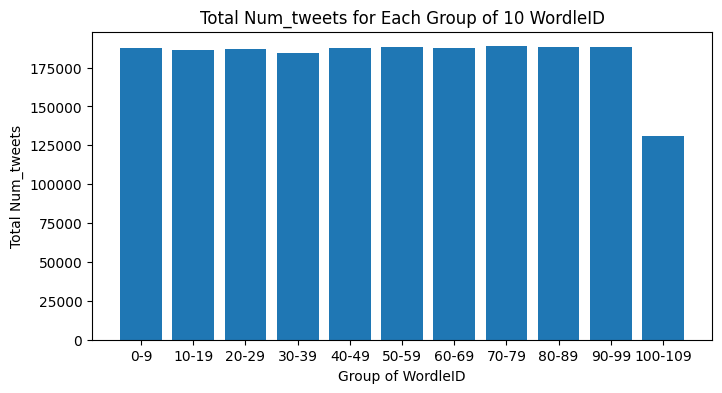

In [172]:
wordle_summary_sorted = wordle_summary.sort_values(by='WordleID')

wordle_summary_grouped = wordle_summary_sorted.groupby(wordle_summary_sorted.index // 10)['Number_of_Games'].sum()

plt.figure(figsize=(8, 4))
plt.bar(range(len(wordle_summary_grouped)), wordle_summary_grouped)
plt.xlabel('Group of WordleID')
plt.ylabel('Total Num_tweets')
plt.title('Total Num_tweets for Each Group of 10 WordleID')
plt.xticks(range(len(wordle_summary_grouped)), [f'{i*10}-{(i+1)*10-1}' for i in range(len(wordle_summary_grouped))])
plt.show()

La partecipazione da parte degli utenti sembra pressocchè costante. 

Per realizzare una rappresentazione OLAP utilizziamo i seguenti parametri:
- Attività di un utente (tanti tweet caratterizzano un utente molto attivo, pochi tweet uno poco attivo)
- Difficoltà di una parola (sulla base della media dei tentativi e del numero di partite perse)
- Orario del tweet (mattino, pomeriggio, sera e notte)

Creiamo una caratteristica _UserActivity_ che per ciascun utente ci indichi quanto questo è attivo. Categorizziamo gli utenti sulla base del numero di tweet da essi pubblicati e il cui contenuto è la propria partita su wordle. 
Per non raggruppare in maniera sbilanciata, facciamoci guidare nella scelta dal seguente boxplot.

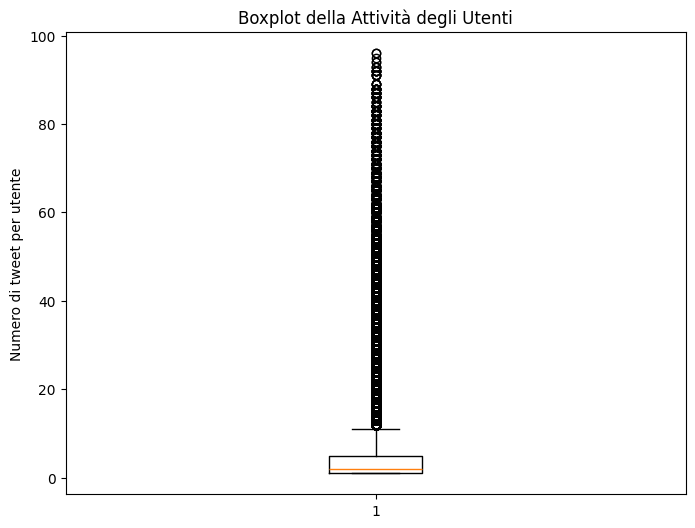

In [173]:
user_activity = wordle['UserID'].value_counts()

plt.figure(figsize=(8, 6))
plt.boxplot(user_activity)
plt.title('Boxplot della Attività degli Utenti')
plt.ylabel('Numero di tweet per utente')
plt.show()

Ricaviamoci con precisione i valori di media, varianza, moda e mediana. 

In [174]:
print("Mean: ", user_activity.mean())
print("Variance: ", user_activity.var())
print("Mode: ", user_activity.mode())
print("Median: ", user_activity.median())

Mean:  4.928695301372862
Variance:  68.99858824541084
Mode:  0    1
Name: count, dtype: int64
Median:  2.0


In [175]:
print(user_activity)

UserID
2.778092e+09    96
5.185310e+08    96
7.569270e+17    95
1.963916e+08    94
1.424114e+18    94
                ..
1.265912e+18     1
8.513366e+17     1
1.462236e+08     1
1.492807e+18     1
7.109468e+17     1
Name: count, Length: 406523, dtype: int64


Contando i valori unici di WordleID siamo in grado di risalire al numero complessivo di parole del giorno presenti nel nostro dataset.

In [176]:
unique_wordle_ids = wordle['WordleID'].nunique()
print("Number of unique WordleIDs:", unique_wordle_ids)

Number of unique WordleIDs: 107


Nel nostro dataset sono presenti 107 parole da indovinare. Il fatto che il numero massimo di partite condivise da un utente sia 96, ossia un valore inferiore a 107 dimostra che i nostri dati sono coerenti.

Usiamo la seguente quantizzazione per il numero di condivisioni di ciascun utente:
1. Low Activity = [1, 2];
2. Medium Activity = [3, 7];
3. High Activity = [8, 49];
4. Very High Activity = [50, 107];

Il motivo per il quale sono stati utilizzati questi numeri per la quantizzazione lo si può capire dal box plot del numero di tweet degli utenti

In [177]:
bins = [0, 3, 8, 50, 107]
labels = ['Low Activity', 'Medium Activity', 'High Activity', 'Very High Activity']

user_macrocategories = pd.cut(user_activity, bins=bins, labels=labels)

wordle = wordle.merge(user_macrocategories.rename('UserActivity'), left_on='UserID', right_index=True)
wordle.head()

,WordleID,ID,Created_At,Source,UserID,Attempts,Hard Mode,Match,Win,Green_Count,Yellow_Count,BlackWhite_Count,UserActivity
0,254,1498447921448034305,2022-02-28 23:59:58+00:00,Twitter for iPhone,3.681676e+07,3,False,"[🟨🟨⬛⬛⬛, 🟨⬛🟨⬛🟩, 🟩🟩🟩🟩🟩]",True,6,4,5,Low Activity
1,254,1498447918184996864,2022-02-28 23:59:58+00:00,Twitter for iPhone,4.825910e+08,4,False,"[⬛⬛⬛⬛🟩, ⬛⬛⬛⬛🟩, ⬛🟩⬛⬛🟩, 🟩🟩🟩🟩🟩]",True,9,0,11,High Activity
2,254,1498447910173921282,2022-02-28 23:59:56+00:00,Twitter for iPhone,1.397624e+18,3,False,"[⬛⬛⬛⬛🟩, ⬛⬛🟩⬛🟩, 🟩🟩🟩🟩🟩]",True,8,0,7,Low Activity
3,254,1498447901797801989,2022-02-28 23:59:54+00:00,Twitter for iPhone,1.255905e+18,3,False,"[⬛⬛⬛🟨⬛, ⬛🟨⬛⬛🟩, 🟩🟩🟩🟩🟩]",True,6,2,7,Low Activity
4,254,1498447896911527938,2022-02-28 23:59:53+00:00,Twitter for iPhone,2.528937e+08,3,False,"[⬛🟨⬛⬛⬛, 🟩🟩🟩⬛🟩, 🟩🟩🟩🟩🟩]",True,9,1,5,Low Activity


Aggiungiamo questa statistica anche al singolo utente

In [263]:
user_stats = pd.merge(user_stats, wordle[['UserID','UserActivity']].drop_duplicates(), on='UserID', how='left')

user_stats.head()

,UserID,Num_tweets,User_Wins,Total_Attempts,User_Win_Rate,Hard_Mode_Count,attempts_Win_1,attempts_Win_2,attempts_Win_3,attempts_Win_4,...,attempts_Win_6,attempts_1,attempts_2,attempts_3,attempts_4,attempts_5,attempts_6,UserCurrentStreak,UserMaxStreak,UserActivity
0,187.0,1,1,2,100.0,0,0.0,1.0,0.0,0.0,...,0.0,0,1,0,0,0,0,1,1,Low Activity
1,422.0,1,1,4,100.0,1,0.0,0.0,0.0,1.0,...,0.0,0,0,0,1,0,0,1,1,Low Activity
2,521.0,3,3,16,100.0,0,0.0,0.0,0.0,1.0,...,2.0,0,0,0,1,0,2,3,3,Low Activity
3,556.0,5,5,19,100.0,0,0.0,0.0,2.0,2.0,...,0.0,0,0,2,2,1,0,5,5,Medium Activity
4,765.0,18,18,75,100.0,0,0.0,0.0,5.0,8.0,...,3.0,0,0,5,8,2,3,18,18,High Activity


Definiamo un'altra quantizzazione in base al periodo della giornata in cui è stato fatto il tweet:
1. Morning = [5, 12];
2. Afternoon = [12, 19];
3. Evening = [19, 24];
4. Night = [0, 5].

In [179]:
wordle['Created_At'] = pd.to_datetime(wordle['Created_At'])

bins = [0, 5, 12, 19, 24]
labels = ['Night','Morning','Afternoon','Evening']

wordle['TimeOfDay'] = pd.cut(wordle['Created_At'].dt.hour, bins=bins, labels=labels, right=False)

n = 5
wordle.sample(n).sort_values(by='TimeOfDay').head(n)

,WordleID,ID,Created_At,Source,UserID,Attempts,Hard Mode,Match,Win,Green_Count,Yellow_Count,BlackWhite_Count,UserActivity,TimeOfDay
1710829,348,1532374568123367425,2022-06-02 14:52:21+00:00,Twitter for Android,3.594735e+08,2,False,"[⬜⬜⬜⬜⬜, 🟩🟩🟩🟩🟩]",True,5,0,5,Low Activity,Afternoon
1971256,367,1539250453837488129,2022-06-21 14:14:40+00:00,Twitter for iPhone,1.732303e+09,4,False,"[⬜🟨⬜🟩🟨, ⬜🟨⬜⬜⬜, ⬜⬜⬜🟨⬜, 🟩🟩🟩🟩🟩]",True,6,4,10,High Activity,Afternoon
2104814,376,1542558519613718528,2022-06-30 17:19:45+00:00,Twitter for Android,1.656386e+07,5,False,"[⬛⬛⬛⬛🟨, 🟨⬛🟨⬛🟩, ⬛🟩🟩🟩🟩, ⬛🟩🟩🟩🟩, 🟩🟩🟩🟩🟩]",True,14,3,8,High Activity,Afternoon
1884271,362,1537507690976579584,2022-06-16 18:49:33+00:00,Twitter for iPhone,8.836609e+17,5,False,"[🟨⬛🟨⬛⬛, ⬛🟨🟨⬛🟩, 🟨🟨⬛🟨🟩, ⬛🟨🟩🟩🟩, 🟩🟩🟩🟩🟩]",True,10,8,7,High Activity,Afternoon
137807,260,1500551036309749761,2022-03-06 19:17:00+00:00,Twitter for iPhone,8.756414e+08,4,False,"[⬛⬛⬛🟨🟨, 🟨⬛⬛🟨🟨, ⬛🟩🟩🟩🟩, 🟩🟩🟩🟩🟩]",True,9,5,6,Low Activity,Evening


Desideriamo conoscere in quali fasce orarie gli utenti sono più attivi. Visualizziamo questa informazione con un bar plot.

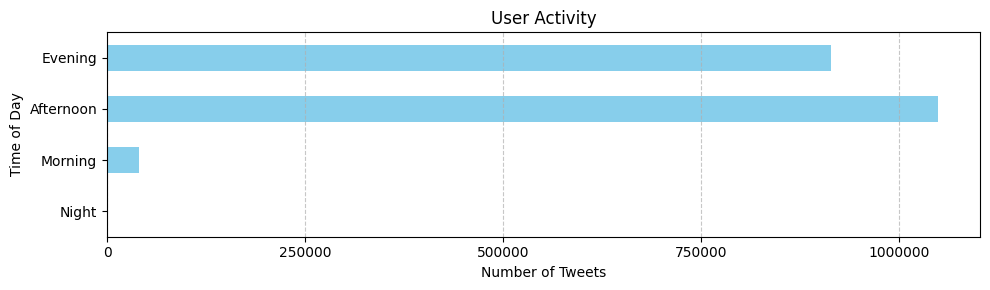

In [180]:
activity_by_time = wordle['TimeOfDay'].value_counts()

activity_by_time = activity_by_time.reindex(labels)

plt.figure(figsize=(10, 3))
activity_by_time.plot(kind='barh', color='skyblue')

# Set tick positions and labels for x-axis
tick_positions = [0, 250000, 500000, 750000, 1000000]
tick_labels = [str(val) for val in tick_positions]

plt.xticks(tick_positions, tick_labels)

plt.title('User Activity')
plt.ylabel('Time of Day')
plt.xlabel('Number of Tweets')

plt.grid(axis='x', linestyle='--', alpha=0.7) 
plt.tight_layout()
plt.show()

La nuova parola del giorno viene rilasciata a mezzanotte della propria ora locale, nel nostro dataset però nessun utente ha condiviso la propria partita nella fascia oraria notturna.

Per assegnare a ciascuna parola un livello di difficoltà:
- Nel caso in cui il numero di sconfitte per quella parola sia maggiore di 2.2 volte il valore medio del numero di sconfitte, la parola è '__Very Hard__'
- Nel caso in cui il numero medio di tentativi per quella parola sia compreso tra 1 e 4.0 e la partita è vinta, la parola è '__Easy__'
- Nel caso in cui il numero medio di tentativi per quella parola sia compreso tra 4.0 e 4.5 e la partita è vinta, la parola è '__Medium__'
- Nel caso in cui il numero medio di tentativi per quella parola sia compreso tra 4.5 e 6 e la partita è vinta, la parola è '__Hard__'

In [181]:
mean_attempts = wordle[wordle['Win']].groupby('WordleID')['Attempts'].mean()

# Categorize WordleIDs based on the criteria
def categorize_difficulty(mean_attempt):
    if mean_attempt >= 4.5:
        return 'Hard'
    elif mean_attempt >= 4.0:
        return 'Medium'
    else:
        return 'Easy'

# Apply the categorization function to each WordleID
wordle['Difficulty'] = wordle['WordleID'].map(mean_attempts).apply(categorize_difficulty)

# Calculate the overall ratio of lost games to total games in the entire DataFrame
overall_lost_games_ratio = wordle[~wordle['Win']].shape[0] / wordle.shape[0]

# Define a function to check if the condition is met for a specific WordleID
def should_update_difficulty(wordle_id):
    wordle_subset = wordle[wordle['WordleID'] == wordle_id]
    lost_games_ratio = wordle_subset[~wordle_subset['Win']].shape[0] / wordle_subset.shape[0]
    return lost_games_ratio > 2.2*overall_lost_games_ratio

# Iterate over each unique WordleID
for unique_id in wordle['WordleID'].unique():
    # Check if the condition is met for the current WordleID
    if should_update_difficulty(unique_id):
        # Update the 'Difficulty' column for rows with the current WordleID
        wordle.loc[wordle['WordleID'] == unique_id, 'Difficulty'] = 'Very Hard'

In [182]:
num_very_hard = (wordle['Difficulty'] == 'Very Hard').sum()

# Print the number of rows
print("Number of rows with Difficulty 'Very Hard':", num_very_hard)

num_very_hard = (wordle['Difficulty'] == 'Hard').sum()
print("Number of rows with Difficulty 'Hard':", num_very_hard)

num_very_hard = (wordle['Difficulty'] == 'Medium').sum()
print("Number of rows with Difficulty 'Medium':", num_very_hard)

num_very_hard = (wordle['Difficulty'] == 'Easy').sum()
print("Number of rows with Difficulty 'Easy':", num_very_hard)

Number of rows with Difficulty 'Very Hard': 182957
Number of rows with Difficulty 'Hard': 167879
Number of rows with Difficulty 'Medium': 824939
Number of rows with Difficulty 'Easy': 827853


Verifichiamo di non aver introdotto per errore valori nulli in questa fase.

In [183]:
print(wordle.isnull().sum())

WordleID            0
ID                  0
Created_At          0
Source              0
UserID              0
Attempts            0
Hard Mode           0
Match               0
Win                 0
Green_Count         0
Yellow_Count        0
BlackWhite_Count    0
UserActivity        0
TimeOfDay           0
Difficulty          0
dtype: int64


Tracciamo un grafico a torta per vedere la distribuzione delle parole in base alla difficoltà

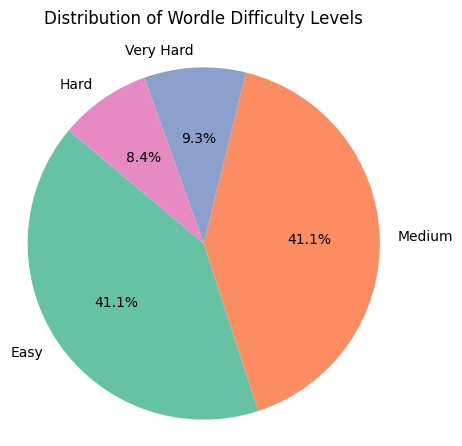

In [184]:
wordle_difficulty = wordle.groupby('WordleID')['Difficulty'].first().reset_index()
difficulty_counts = wordle_difficulty['Difficulty'].value_counts()

colors = plt.cm.Set2.colors

plt.figure(figsize=(5, 5))
plt.pie(difficulty_counts, labels=difficulty_counts.index, autopct='%1.1f%%', startangle=140, colors = colors)
plt.title('Distribution of Wordle Difficulty Levels', pad=20)
plt.axis('equal')  
plt.show()


Un'altra informazione che può risultare utile da visualizzare è da quale dispositivo vengono fatti i tweet.
Andiamo a visualizzare intanto i valori unici che assume la colonna 'Source' 

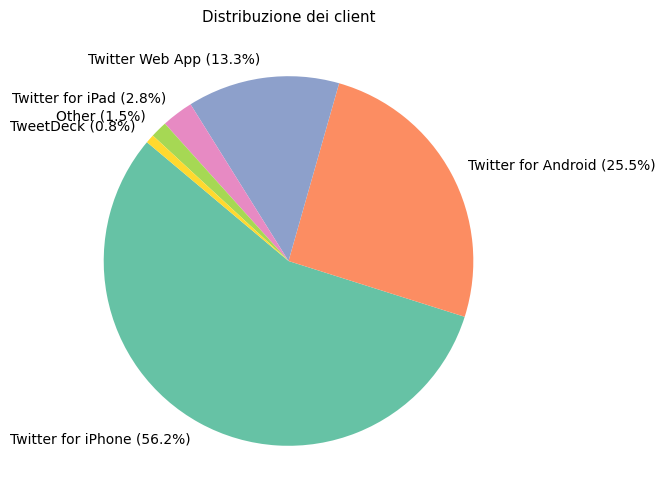

In [185]:
valori_client = wordle['Source'].value_counts()
plt.figure(figsize=(6, 6))
pie = plt.pie(valori_client, labels=valori_client.index, startangle=140, colors=colors)

plt.rcParams['font.size'] = 9

# Get the wedges and labels of the pie chart
wedges, labels = pie[0], pie[1]

for i, (wedge, label) in enumerate(zip(wedges, labels)):
    percentage = 100 * valori_client.iloc[i] / valori_client.sum()
    label.set_text(f"{label.get_text()} ({percentage:.1f}%)")

plt.title('Distribuzione dei client')
plt.show()

Si può vedere che il client più utilizzato è l'app di Twitter per iPhone, quindi gli iPhone users sono quelli che nella popolazione twittano di più. 

### OLAP

Ora che è terminata la preparazione dei dati, procediamo con la analisi OLAP.

In [186]:
quantize_user_activity = ['Low Activity', 'Medium Activity', 'High Activity', 'Very High Activity']
quantize_time_of_day = ['Morning', 'Afternoon', 'Evening', 'Night']
quantize_difficulty = ['Easy', 'Medium', 'Hard', 'Very Hard']

OLAP = np.zeros((len(quantize_user_activity),len(quantize_time_of_day),len(quantize_difficulty)))
for z in range(len(quantize_user_activity)):
    for j in range(len(quantize_time_of_day)):
        for i in range(len(quantize_difficulty)):
            # Filter dataframe
            filtered_data = wordle[(wordle['UserActivity'] == quantize_user_activity[z]) &
                                   (wordle['TimeOfDay'] == quantize_time_of_day[j]) &
                                   (wordle['Difficulty'] == quantize_difficulty[i])]
            # Calculate number of wins
            wins = filtered_data['Win'].sum()
            
            # Calculate number of matches
            matches = len(filtered_data)
            
            # Compute ratio of wins to matches (avoid division by zero)
            ratio = wins / matches * 100 if matches > 0 else np.nan
            
            # Populate OLAP cube
            OLAP[z, j, i] = ratio
OLAP

array([[[ 98.80418535,  98.25673534,          nan,  90.98497496],
        [ 98.50791395,  97.49666597,  93.86846457,  81.53318791],
        [ 98.62552473,  97.53104417,  95.23254685,  81.48188743],
        [         nan,          nan,          nan,          nan]],

       [[ 99.13232104,  98.25394135,          nan,  94.27580225],
        [ 98.90874998,  97.90839328,  95.49801952,  89.95271178],
        [ 98.9099637 ,  97.86641025,  96.38739431,  91.04007815],
        [         nan,          nan,          nan,          nan]],

       [[ 99.44618793,  98.90401672,          nan,  95.50115779],
        [ 99.20602515,  98.50027315,  96.70273328,  89.83644025],
        [ 99.09471977,  98.3891017 ,  96.87621207,  90.20856992],
        [         nan,          nan,          nan,          nan]],

       [[ 98.27586207,  98.48484848,          nan, 100.        ],
        [ 99.23509087,  98.54642331,  97.20637185,  87.93445879],
        [ 99.31563511,  98.49756098,  97.30397663,  88.5583524 ],
    

Facciamo uno slicing rispetto a TimeOfDay. Poichè la sera e il pomeriggio sono le fasce orarie di picco le prediligiamo. 

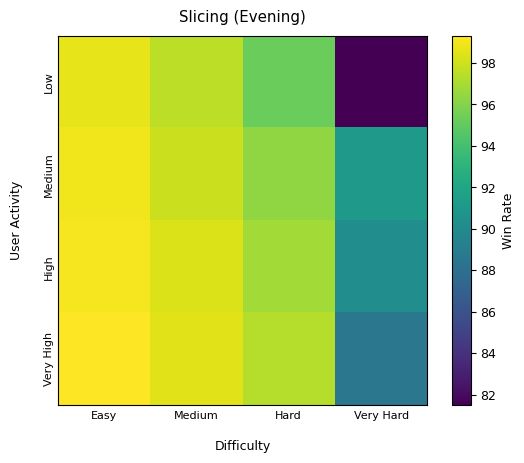

In [187]:
plt.imshow(OLAP[:, 2, :])
for i, label in enumerate(quantize_difficulty):
    plt.text(i, 3.65, label, ha='center', fontsize=8)
for i, label in enumerate(quantize_user_activity):
    label = label.replace(" Activity", "") 
    plt.text(-0.65, i, label, va='center', fontsize=8, rotation=90)
plt.xlabel('Difficulty', labelpad=25)
plt.ylabel('User Activity', labelpad=25)
plt.title('Slicing (Evening)', pad=10)
plt.colorbar(label='Win Rate')
plt.yticks([])
plt.xticks([])

plt.show() 

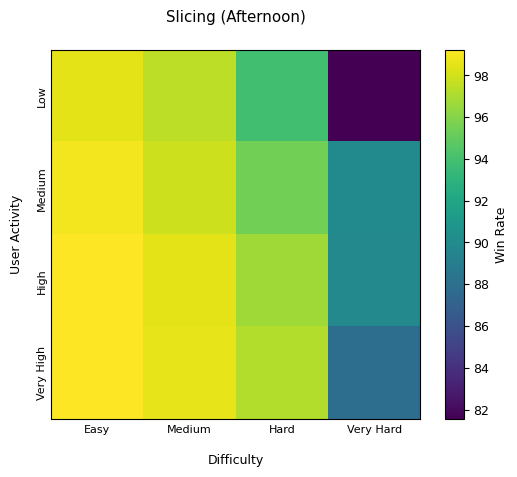

In [188]:
plt.imshow(OLAP[:, 1, :])
for i, label in enumerate(quantize_difficulty):
    plt.text(i, 3.65, label, ha='center', fontsize=8)
for i, label in enumerate(quantize_user_activity):
    label = label.replace(" Activity", "") 
    plt.text(-0.65, i, label, va='center', fontsize=8, rotation=90)
plt.xlabel('Difficulty', labelpad=25)
plt.ylabel('User Activity', labelpad=20)
plt.title('Slicing (Afternoon)', pad=20)
plt.colorbar(label='Win Rate')
plt.yticks([])
plt.xticks([])

plt.show()

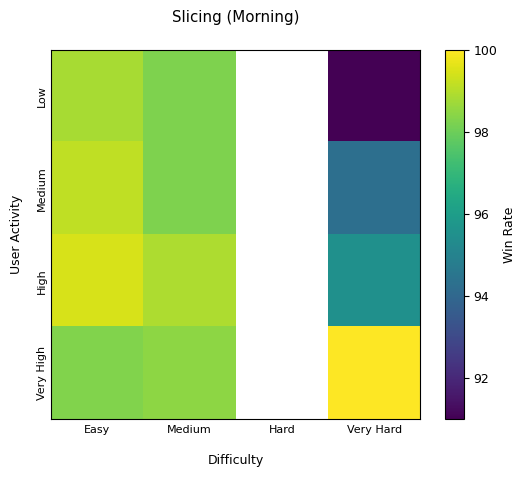

In [189]:
plt.imshow(OLAP[:, 0, :])
for i, label in enumerate(quantize_difficulty):
    plt.text(i, 3.65, label, ha='center', fontsize=8)
for i, label in enumerate(quantize_user_activity):
    label = label.replace(" Activity", "") 
    plt.text(-0.65, i, label, va='center', fontsize=8, rotation=90)
plt.xlabel('Difficulty', labelpad=25)
plt.ylabel('User Activity', labelpad=20)
plt.title('Slicing (Morning)', pad=20)
plt.colorbar(label='Win Rate')
plt.yticks([])
plt.xticks([])

plt.show()

Possiamo notare come, in tutte le visualizzazioni sopra, il tasso di vittoria degli utenti medio attivi, attivi e molto attivi sia generalmente maggiore del tasso di vittoria del utenti poco attivi, in particolare in caso di parole molto difficili.

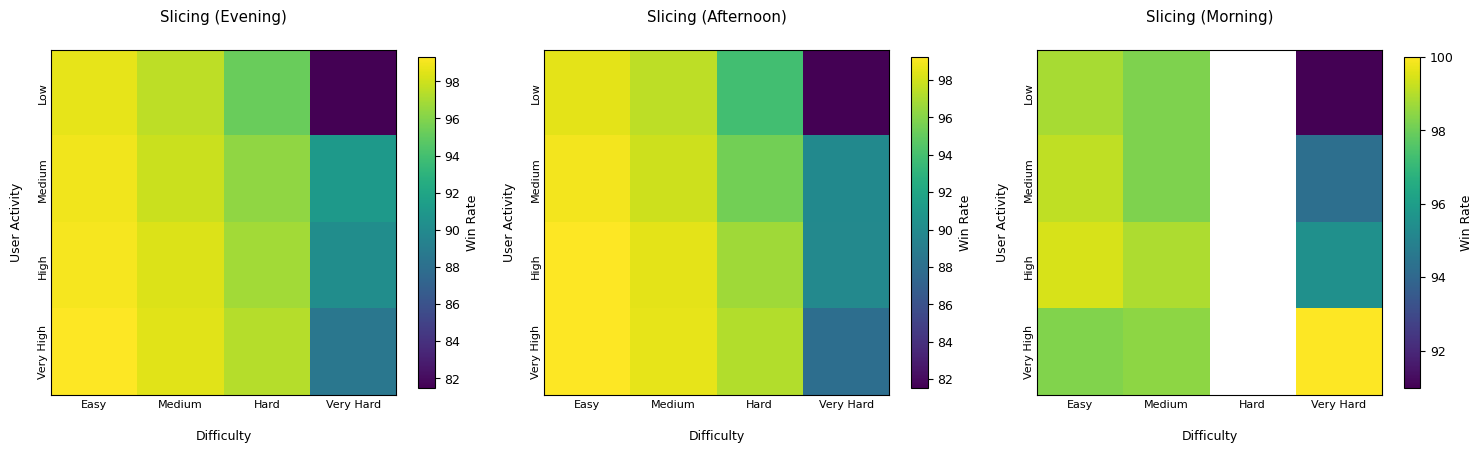

In [190]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

im1 = axs[0].imshow(OLAP[:, 2, :])
for i, label in enumerate(quantize_difficulty):
    axs[0].text(i, 3.65, label, ha='center', fontsize=8)
for i, label in enumerate(quantize_user_activity):
    label = label.replace(" Activity", "") 
    axs[0].text(-0.65, i, label, va='center', fontsize=8, rotation=90)
axs[0].set_xlabel('Difficulty', labelpad=25)
axs[0].set_ylabel('User Activity', labelpad=20)
axs[0].set_title('Slicing (Evening)', pad=20)
fig.colorbar(im1, ax=axs[0], label='Win Rate', shrink=0.7)
axs[0].set_yticks([])
axs[0].set_xticks([])

im2 = axs[1].imshow(OLAP[:, 1, :])
for i, label in enumerate(quantize_difficulty):
    axs[1].text(i, 3.65, label, ha='center', fontsize=8)
for i, label in enumerate(quantize_user_activity):
    label = label.replace(" Activity", "") 
    axs[1].text(-0.65, i, label, va='center', fontsize=8, rotation=90)
axs[1].set_xlabel('Difficulty', labelpad=25)
axs[1].set_ylabel('User Activity', labelpad=20)
axs[1].set_title('Slicing (Afternoon)', pad=20)
fig.colorbar(im2, ax=axs[1], label='Win Rate', shrink=0.7)
axs[1].set_yticks([])
axs[1].set_xticks([])

im3 = axs[2].imshow(OLAP[:, 0, :])
for i, label in enumerate(quantize_difficulty):
    axs[2].text(i, 3.65, label, ha='center', fontsize=8)
for i, label in enumerate(quantize_user_activity):
    label = label.replace(" Activity", "") 
    axs[2].text(-0.65, i, label, va='center', fontsize=8, rotation=90)
axs[2].set_xlabel('Difficulty', labelpad=25)
axs[2].set_ylabel('User Activity', labelpad=20)
axs[2].set_title('Slicing (Morning)', pad=20)
fig.colorbar(im3, ax=axs[2], label='Win Rate', shrink=0.7)
axs[2].set_yticks([])
axs[2].set_xticks([])

plt.tight_layout()  
plt.show()

Facendo dicing verifichiamo la decrescita del tasso di vincinta per gli utenti poco attivi (_Low Activity_) e gli utenti molto attivi (_Very High Activity_) consideando come fascia oraria la sera.

In [191]:
print(OLAP[0, 2, :])
print(OLAP[3, 2, :])

[98.62552473 97.53104417 95.23254685 81.48188743]
[99.31563511 98.49756098 97.30397663 88.5583524 ]


Possiamo notare come la decrescita del tasso di vincita sia più attenuata nel caso di utenti molto attivi e come il divario nel tasso di vincinta aumenti all'aumentare della difficoltà delle parole. Visualizziamo questa informazone con un grafico a linea.

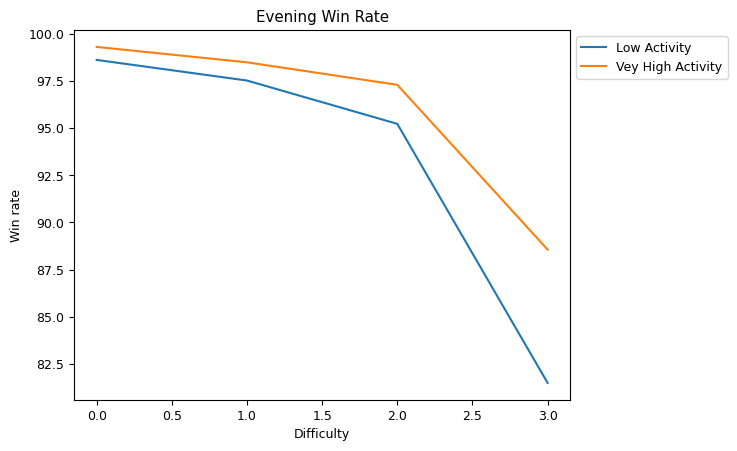

In [192]:
plt.xlabel('Difficulty')
plt.ylabel('Win rate')
plt.title('Evening Win Rate')
plt.plot(OLAP[0, 2, :], label='Low Activity') 
plt.plot(OLAP[3, 2, :], label='Vey High Activity') 
plt.legend(bbox_to_anchor=(1, 1), loc='upper left') 
plt.show() 

## Test statistici

### T-Test sull'attività degli utenti

Utilizziamo un T-test a una coda.

- $H_0$ = gli utenti molto attivi in caso di vittoria si comportano allo stesso modo della totalità degli utenti in caso di vittoria.

- $H_a$ = la media dei tentativi degli utenti molto attivi in caso di vittoria è minore della media dei tentativi della totalità degli utenti in caso di vittoria. 

Prendiamo come livello di significatività 0.05. Sussiste una differenza statisticamente significativa?

Sappiamo che si devono verificare alcune ipotesi:
1. Campione con numero di elementi n > 30;
2. Popolazione N almeno dieci volte superiore al campione N > 10*n.

Stampiamo il numero di elementi per le due classi. 

In [193]:
winning_attempts = wordle.loc[wordle['Win'] == 1, 'Attempts']
winning_attempts_mean = wordle.loc[wordle['Win'] == 1, 'Attempts'].mean()
winning_attempts_very_high_activity = wordle.loc[(wordle['UserActivity'] == 'Very High Activity') & (wordle['Win'] == 1), 'Attempts']
print(len(winning_attempts))
print(len(winning_attempts_very_high_activity))

if len(winning_attempts_very_high_activity) >= 30:
    print("Sample size condition (n ≥ 30) is met.")
else:
    print("Sample size condition (n ≥ 30) is not met.")

if len(winning_attempts) >= 10 * (len(winning_attempts_very_high_activity)):
    print("Population size condition (N ≥ 10*n) is met.")
else:
    print("Population size condition (N ≥ 10*n) is not met.")

1952040
150874
Sample size condition (n ≥ 30) is met.
Population size condition (N ≥ 10*n) is met.


Le condizioni per il t-test sono soddisfatte. Passiamo quindi alla costruzione del test.

In [194]:
t_value, p_value = stats.ttest_1samp(winning_attempts_very_high_activity, winning_attempts_mean, alternative='less')

print("p-value:", p_value)

p-value: 1.0


Il p-value è maggiore del livello di significatività: non possiamo rigettare l'ipotesi nulla.  
Cerchiamo di comprendere meglio questo risultato impostando un t-test a due code.

In [195]:
t_value, p_value = stats.ttest_1samp(winning_attempts_very_high_activity, winning_attempts_mean)

print("p-value:", p_value)

p-value: 1.7570568947727068e-17


Il p-value risultante è decisamente minore del livello di significatività, possiamo allora rigettare l'ipotesi nulla in favore dell'alternativa. Possiamo quindi concludere che gli utenti molto attivi in caso di vittoria non si comportano allo stesso modo della totalità degli utenti in caso di vittoria.  
Impostiamo quindi un'ultimo t-test a una coda.

In [196]:
tt_value, p_value = stats.ttest_1samp(winning_attempts_very_high_activity, winning_attempts_mean, alternative='greater')

print("p-value:", p_value)

p-value: 8.785284473863534e-18


Anche in questo caso il p-value risulta essere decisamente minore rispetto al livello di significatività: possiamo rigettare l'ipotesi nulla in favore dell'alternativa. Pertanto, esistono prove evidenti che ci suggeriscono che il valore medio dei tentativi in caso di vittoria degli utenti molto attivi è significativamente maggiore della media dei tentativi in caso di vittoria della popolazione

Possiamo allora immaginare che:
- gli utenti che condividono di più risultano più propensi a condividere anche le proprie sconfitte.
- gli utenti che condividono maggiormente prediligono la modalità difficile che richiede più tentativi (senza la modalità difficile infatti è possibile inserire in ciascun tentativo anche le lettere non indovinate in precedenza. Questo permette di trovare tutte le lettere della parola, provandole tutte di tentativo in tenativo).

Ovviamente bisogna sempre tenere presente che le osservazioni appena fatte sono ipotesi e ***non*** cause. 

### T-Test sui Client 


Siccome circa la metà dei tweet provengono dal Client di iPhone, proviamo a impostare un T-Test con le seguente ipotesi
- $H_0$ = gli utenti che twittano da iPhone hanno la stesso media dei tentativi in caso di vittoria rispetto all'intera popolazione
- $H_a$ = gli utenti che twittano da iPhone hanno una media di tentativi in caso di vittoria diversa da quella degli altri client

In [197]:
iphone_users_attempts = wordle.loc[(wordle['Source'] == 'Twitter for iPhone') & (wordle['Win'] == 1), 'Attempts']
other_users_attempts = other_users_attempts = wordle.loc[(wordle['Source'] != 'Twitter for iPhone') & (wordle['Win'] == 1), 'Attempts']
print("Tweet provenienti da Iphone: ", len(iphone_users_attempts))
print("Tweet provenienti da altri client: ", len(other_users_attempts))

statistica_t, valore_p = stats.ttest_ind(iphone_users_attempts, other_users_attempts)

print("Statistiche t:", statistica_t)
print("Valore p:", valore_p)

Tweet provenienti da Iphone:  1099681
Tweet provenienti da altri client:  852359
Statistiche t: -21.220184317212905
Valore p: 6.382278288599869e-100


Possiamo rigettare l'ipotesi nulla in favore dell'alternativa. I tweet provenienti da iPhone presentano una media di tentativi in caso di vittoria diversa dai tweet provenienti dagli altri client. 
Possiamo allora chiederci: è possibile associare un utente a un solo client per rendere questo un confronto tra utenti?
Vediamo se esiste una corrispondenza biunivoca.

In [198]:
user_source_counts = wordle.groupby('UserID')['Source'].nunique()

users_with_multiple_sources = user_source_counts[user_source_counts > 1].index

wordle_filtered = wordle[wordle['UserID'].isin(users_with_multiple_sources)]

print("Utenti che condividono da client diversi: ", users_with_multiple_sources.shape[0])

Utenti che condividono da client diversi:  16542


Poichè esistono utenti che condividono le proprie partite da client diversi, la risposta alla domanda precedente è no.

### Test di Kruskal Wallis

Possiamo confrontare un tipo di dato numerico (Indice di vittoria?) e una categorica (User Activity).

Nel nostro caso potremmo utilizzare il dataset user_stats, dove la categoria è la User Activity e il parametro è la Win Rate per valutare de effettivamente l'attività di un utente influisce la sua "efficacia".

Assunzioni:

- Ogni sample non deve avere una distribuzione normale;
    - possiamo fare dei test
- La selezione dei sample deve essere indipendente;
- Il dato numerico deve essere un ordinale o può essere classificato.

Verifichiamo che non ci sia una distribuzione normale

In [199]:
from scipy.stats import kruskal

user_lowactivity = user_stats[user_stats['UserActivity'] == 'Low Activity']['User_Win_Rate']
user_mediumactivity = user_stats[user_stats['UserActivity'] == 'Medium Activity']['User_Win_Rate']
user_highactivity = user_stats[user_stats['UserActivity'] == 'High Activity']['User_Win_Rate']
user_veryhighactivity = user_stats[user_stats['UserActivity'] == 'Very High Activity']['User_Win_Rate']

data = [user_lowactivity, user_mediumactivity, user_highactivity, user_veryhighactivity]

for user in data:
    res = stats.normaltest(user)
    print(res)

NormaltestResult(statistic=235658.82474806136, pvalue=0.0)
NormaltestResult(statistic=56653.31984596826, pvalue=0.0)
NormaltestResult(statistic=53254.10582237799, pvalue=0.0)
NormaltestResult(statistic=2743.0111714862287, pvalue=0.0)


Possiamo quindi costruire il test
- $H_0$ = Tutti i tipi di utente performano allo stesso modo (la mediana del tasso di vincita per utente è la stessa nei quattro gruppi)

- $H_a$ = Non tutti i tipi di utente performano allo stesso modo (la mediana del tasso di vincita per utente non è la stessa nei quattro gruppi)

In [200]:

statistic, p_value = kruskal(user_lowactivity, user_mediumactivity, user_highactivity, user_veryhighactivity)
print("Kruskal-Wallis test statistic:", statistic)
print("P-value:", p_value)

Kruskal-Wallis test statistic: 16266.87229728007
P-value: 0.0


Siccome il p-value è nullo (valore talmente piccolo che viene mostrato 0) proviamo a rieffettuare il test su un campione corrispondente al 5% dell'intero dataset

In [201]:
sample_size = int(user_stats.shape[0]/100)*5

user_stats_sample = user_stats.sample(sample_size, random_state=16)

print(user_stats_sample.shape)

user_lowactivity = user_stats_sample[user_stats_sample['UserActivity'] == 'Low Activity']['User_Win_Rate']
user_mediumactivity = user_stats_sample[user_stats_sample['UserActivity'] == 'Medium Activity']['User_Win_Rate']
user_highactivity = user_stats_sample[user_stats_sample['UserActivity'] == 'High Activity']['User_Win_Rate']
user_veryhighactivity = user_stats_sample[user_stats_sample['UserActivity'] == 'Very High Activity']['User_Win_Rate']

(20325, 15)


Verifichiamo anche per il sample se la distribuzione dei dati è normale (data la dimensionalità del dataset, possiamo in questo modo visualizzare dei p-value diversi da 0)

In [202]:
data = [user_lowactivity, user_mediumactivity, user_highactivity, user_veryhighactivity]


for user in data:
    res = stats.normaltest(user)
    print(res)

NormaltestResult(statistic=11977.56907425954, pvalue=0.0)
NormaltestResult(statistic=2967.3298753358868, pvalue=0.0)
NormaltestResult(statistic=3012.1127789042366, pvalue=0.0)
NormaltestResult(statistic=109.02306449824948, pvalue=2.11807992540956e-24)


In [203]:

statistic, p_value = kruskal(user_lowactivity, user_mediumactivity, user_highactivity, user_veryhighactivity)

print("Kruskal-Wallis test statistic:", statistic)
print("P-value:", p_value)

Kruskal-Wallis test statistic: 960.8453734618582
P-value: 5.607848512696141e-208


Il p-value suggerisce di rigettare l'ipotesi nulla a favore di quella alternativa, quindi si può pensare che l'attività di un utente incida sul tasso di vincita.

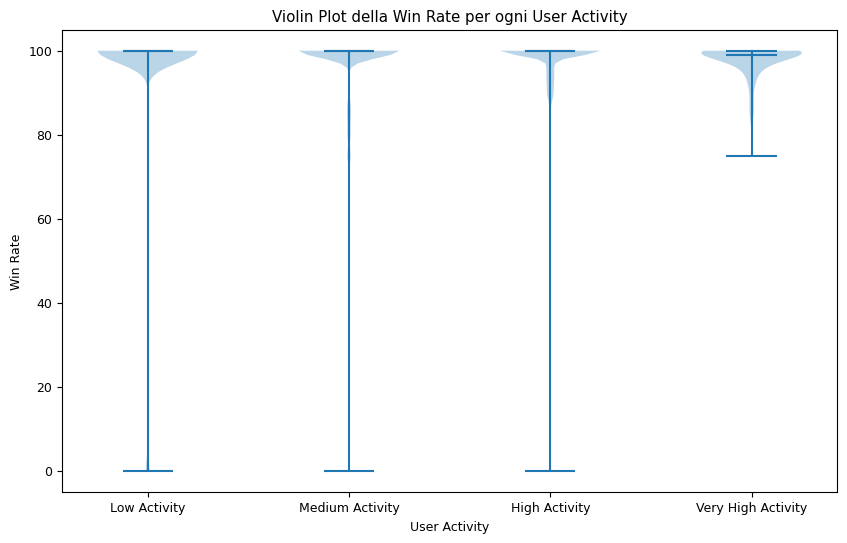

In [204]:
plt.figure(figsize=(10, 6))
plt.violinplot(data, showmeans=False, showmedians=True)
plt.xticks(range(1, len(user_stats['UserActivity'].unique()) + 1), user_stats['UserActivity'].unique())
plt.title('Violin Plot della Win Rate per ogni User Activity')
plt.xlabel('User Activity')
plt.ylabel('Win Rate')
plt.show()

Possiamo notare come per gli utenti attivi e mediamente attivi vi sia una maggiore concentrazione intorno al 100%, mentre così non è per gli utenti molto attivi. Tuttavia è più probabile che gli utenti che condividono "sempre" siano più propensi a condividere anche le sconfitte. Si può inoltre osservare che per gli utenti molto attivi il tasso di vinvita ha un valore minimo intorno al 50%.

### Test chi-quadrato

Verifichiamo che siano verificate le condizioni per costruire un test chi-quadrato.
- Abbiamo almeno 5 conteggi? Si;
- Le singole osservazioni sono indipendenti? Si;
- Le dimensioni della popolazione sono almeno 10 volte quelle del campione? Si.

Costruiamo il test:
- $H_0$ = il numero di condivisioni per parola è pressoché uniformemente distribuito, quindi la partecipazione su Twitter da parte degli utenti che giocano a Wordle è costante.
- $H_a$ = il numero di condivisioni per parola non è uniformemente distribuito, quindi la partecipazione su Twitter da parte degli utenti che giocano a Wordle non è costante.

In [205]:
observed_frequencies = wordle_summary['Number_of_Games']
print(observed_frequencies)

0      18694
1      18592
2      18797
3      18866
4      18691
       ...  
102    18700
103    18906
104    18754
105    18713
106    18591
Name: Number_of_Games, Length: 107, dtype: int64


In [249]:
total_obs = wordle_summary['Number_of_Games'].sum() 
total_words = 107  
expected_frequency = total_obs / total_words

print(expected_frequency)

18725.495327102803


In [250]:
value1 = 18725
value2 = 18726
length = 107  

expected_frequencies = np.full(length, value1)
expected_frequencies[1::2] = value2
print( observed_frequencies.sum() - expected_frequencies.sum() )

0


In [251]:
chi, p_value = stats.chisquare(f_obs=observed_frequencies, f_exp=expected_frequencies)

print("Chi-square statistic:", chi)
print("P-value:", p_value)

Chi-square statistic: 218.5434490588541
P-value: 8.199514412446538e-10


Per 107-1=106 classi e un livello di significatività di 0.05, il valore del chi-quadrato è 131.031. Poichè 218.5 è maggiore di 131, possiamo rifiutare l'ipotesi nulla secondo cui la proporzione del numero di condivisioni tra le parole sarebbe pressoché la stessa.

## Metodi Predittivi

### Codifica dei dati

In [209]:
wordle_coded = wordle.copy() 
wordle_coded.drop(columns=['Match'], axis = 1, inplace=True)

Codifichiamo i dati. Partiamo dalle caratteristiche booleane.

In [210]:
wordle_coded['Hard Mode'] = wordle_coded['Hard Mode'].astype(int)
wordle_coded['Win'] = wordle_coded['Win'].astype(int)
wordle_coded.head()

,WordleID,ID,Created_At,Source,UserID,Attempts,Hard Mode,Win,Green_Count,Yellow_Count,BlackWhite_Count,UserActivity,TimeOfDay,Difficulty
0,254,1498447921448034305,2022-02-28 23:59:58+00:00,Twitter for iPhone,3.681676e+07,3,0,1,6,4,5,Low Activity,Evening,Easy
1,254,1498447918184996864,2022-02-28 23:59:58+00:00,Twitter for iPhone,4.825910e+08,4,0,1,9,0,11,High Activity,Evening,Easy
2,254,1498447910173921282,2022-02-28 23:59:56+00:00,Twitter for iPhone,1.397624e+18,3,0,1,8,0,7,Low Activity,Evening,Easy
3,254,1498447901797801989,2022-02-28 23:59:54+00:00,Twitter for iPhone,1.255905e+18,3,0,1,6,2,7,Low Activity,Evening,Easy
4,254,1498447896911527938,2022-02-28 23:59:53+00:00,Twitter for iPhone,2.528937e+08,3,0,1,9,1,5,Low Activity,Evening,Easy


Ora iniziamo a convertire i valori qualitativi in valori quantitativi tramite una codifica ordinale, iniziamo da TimeOfDay, in ordine crescente in base al momento del giorno

In [211]:
ordinal_mapping = {'Morning': 1, 'Afternoon': 2, 'Evening': 3, 'Night': 4}
wordle_coded['TimeOfDay'] = wordle_coded['TimeOfDay'].map(ordinal_mapping)
wordle_coded.head()


,WordleID,ID,Created_At,Source,UserID,Attempts,Hard Mode,Win,Green_Count,Yellow_Count,BlackWhite_Count,UserActivity,TimeOfDay,Difficulty
0,254,1498447921448034305,2022-02-28 23:59:58+00:00,Twitter for iPhone,3.681676e+07,3,0,1,6,4,5,Low Activity,3,Easy
1,254,1498447918184996864,2022-02-28 23:59:58+00:00,Twitter for iPhone,4.825910e+08,4,0,1,9,0,11,High Activity,3,Easy
2,254,1498447910173921282,2022-02-28 23:59:56+00:00,Twitter for iPhone,1.397624e+18,3,0,1,8,0,7,Low Activity,3,Easy
3,254,1498447901797801989,2022-02-28 23:59:54+00:00,Twitter for iPhone,1.255905e+18,3,0,1,6,2,7,Low Activity,3,Easy
4,254,1498447896911527938,2022-02-28 23:59:53+00:00,Twitter for iPhone,2.528937e+08,3,0,1,9,1,5,Low Activity,3,Easy


Analogamente si fa per Source, UserActivity, Difficulty

In [212]:
# UserActivity
ordinal_mapping = {'Low Activity': 1, 'Medium Activity': 2, 'High Activity': 3, 'Very High Activity': 4}
wordle_coded['UserActivity'] = wordle_coded['UserActivity'].map(ordinal_mapping)
# Source
ordinal_mapping = {'Twitter for iPhone' : 1, 'Twitter for Android' : 2, 'Twitter Web App' : 3, 'Twitter for iPad' : 4, 'Other' : 5, 'TweetDeck' : 6}
wordle_coded['Source'] = wordle_coded['Source'].map(ordinal_mapping)
# Difficulty
ordinal_mapping = {'Easy':1, 'Medium':2, 'Hard':3, 'Very Hard':4}
wordle_coded['Difficulty'] = wordle_coded['Difficulty'].map(ordinal_mapping)

wordle_coded.head()

,WordleID,ID,Created_At,Source,UserID,Attempts,Hard Mode,Win,Green_Count,Yellow_Count,BlackWhite_Count,UserActivity,TimeOfDay,Difficulty
0,254,1498447921448034305,2022-02-28 23:59:58+00:00,1,3.681676e+07,3,0,1,6,4,5,1,3,1
1,254,1498447918184996864,2022-02-28 23:59:58+00:00,1,4.825910e+08,4,0,1,9,0,11,3,3,1
2,254,1498447910173921282,2022-02-28 23:59:56+00:00,1,1.397624e+18,3,0,1,8,0,7,1,3,1
3,254,1498447901797801989,2022-02-28 23:59:54+00:00,1,1.255905e+18,3,0,1,6,2,7,1,3,1
4,254,1498447896911527938,2022-02-28 23:59:53+00:00,1,2.528937e+08,3,0,1,9,1,5,1,3,1


Siccome Created_At non aggiunge ulteriori informazioni, dato che WordleID indica in un certo senso il giorno e l'orario è presente nella colonna TimeOfDay, quindi decidiamo di eliminare questa colonna

In [213]:
wordle_coded.drop(columns=['Created_At', 'ID', 'UserID'], axis = 1, inplace=True)
wordle_coded.head()

,WordleID,Source,Attempts,Hard Mode,Win,Green_Count,Yellow_Count,BlackWhite_Count,UserActivity,TimeOfDay,Difficulty
0,254,1,3,0,1,6,4,5,1,3,1
1,254,1,4,0,1,9,0,11,3,3,1
2,254,1,3,0,1,8,0,7,1,3,1
3,254,1,3,0,1,6,2,7,1,3,1
4,254,1,3,0,1,9,1,5,1,3,1


### Normalizzazione

Una volta codificati i campioni, li normalizziamo per poter eseguire dei confronti.

In [214]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(wordle_coded)

# visualizziamo la normalizzazione
X_scaled.view()

array([[0.        , 0.        , 0.4       , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.6       , ..., 0.66666667, 1.        ,
        0.        ],
       [0.        , 0.        , 0.4       , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [1.        , 0.        , 0.6       , ..., 0.        , 0.        ,
        0.33333333],
       [1.        , 0.4       , 0.2       , ..., 0.33333333, 0.        ,
        0.33333333],
       [1.        , 0.2       , 0.6       , ..., 0.33333333, 0.        ,
        0.33333333]])

### Regressione Lineare

Abbiamo visto che ci sono tre metriche per valutare i modelli:

- lo scarto medio assoluto (MAE - Mean Absolute Error);
- l’errore quadratico medio (MSE - Mean Squared Error);
- la radice dell’errore quadratico medio (RMSE - Root of Mean Squared Error).  

Implementiamo le funzioni per il calcolo dell'MSE, dell'MAE e del RMSE: ci serviranno per valutare se il modello ottenuto è accettabile o meno.

In [215]:
# sommatoria del quadrato della differenza tra y vera e y predetta diviso il numero di y -> MSE
def MSE (y_pred,y_true):
   return 1/y_pred.shape[0] * np.abs((y_pred-y_true)).sum()

# sommatoria del valore assoluto della differenza tra y vera e y predetta diviso il numero di y -> MAE
def MAE (y_pred,y_true):
     return 1/y_pred.shape[0] * ((y_pred-y_true)**2).sum()

# radice della sommatoria del quadrato della differenza tra y vera e y predetta diviso il numero di y -> RMSE
def RMSE (y_pred,y_true):
     return np.sqrt(1/y_pred.shape[0] * ((y_pred-y_true)**2).sum())

#### User_stats

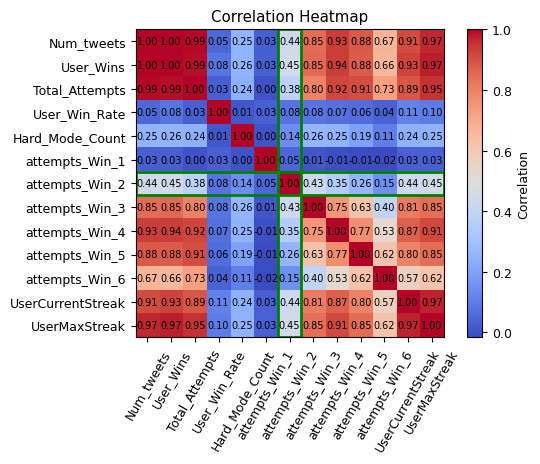

In [216]:
from matplotlib.patches import Rectangle

features = user_stats.drop(columns=['UserActivity', 'UserID'])
user_norm = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)

r = user_norm.corr()

plt.figure(figsize=(6, 4))
plt.imshow(r, cmap='coolwarm', interpolation='nearest')

for i in range(len(r.columns)):
    for j in range(len(r.columns)):
        plt.text(j, i, "{:.2f}".format(r.iloc[i, j]), ha='center', va='center', color='black', fontsize=7)

highlight_row = r.index.get_loc('attempts_Win_2')
rect = Rectangle((-0.5, highlight_row - 0.5), len(r.columns), 1, linewidth=2, edgecolor='green', facecolor='none')
plt.gca().add_patch(rect)

highlight_col = r.columns.get_loc('attempts_Win_2')
col_rect = Rectangle((highlight_col - 0.5, -0.5), 1, len(r.columns), linewidth=2, edgecolor='green', facecolor='none')
plt.gca().add_patch(col_rect)

plt.colorbar(label='Correlation')
plt.title('Correlation Heatmap')
plt.xticks(range(len(r.columns)), r.columns, rotation=60)
plt.yticks(range(len(r.columns)), r.columns)
plt.show()

In [217]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
# Dividi il dataset in features (X) e variabile dipendente (y)
X = user_stats[['attempts_Win_2', 'attempts_Win_4', 'attempts_Win_5', 'attempts_Win_6']]
y = user_stats['attempts_Win_3']

X_scaled_regression = scaler.fit_transform(X)
# Dividi il dataset in set di addestramento e di test
X_train, X_test, y_train, y_test = train_test_split(X_scaled_regression, y, test_size=0.2, random_state=42)

# Crea un'istanza del modello di regressione lineare
model = LinearRegression()

# Addestra il modello sui dati di addestramento
model.fit(X_train, y_train)

# Fai previsioni sui dati di test
y_pred = model.predict(X_test)

In [218]:
mean_attempts = y_test.mean()

null_model_y = np.ones(len(y_test))*mean_attempts

print("MSE del nostro modello: ", MSE(y_pred, y_test))
print("MSE del modello nullo: ", MSE(null_model_y, y_test))

MSE del nostro modello:  0.9212811280574862
MSE del modello nullo:  1.2871028352641893


#### Wordle

In [219]:
wordle_coded.head()

,WordleID,Source,Attempts,Hard Mode,Win,Green_Count,Yellow_Count,BlackWhite_Count,UserActivity,TimeOfDay,Difficulty
0,254,1,3,0,1,6,4,5,1,3,1
1,254,1,4,0,1,9,0,11,3,3,1
2,254,1,3,0,1,8,0,7,1,3,1
3,254,1,3,0,1,6,2,7,1,3,1
4,254,1,3,0,1,9,1,5,1,3,1


Ricorrendo a una heatmap cerchiamo di comprendere se ci sono caratteristiche che variano insieme. 

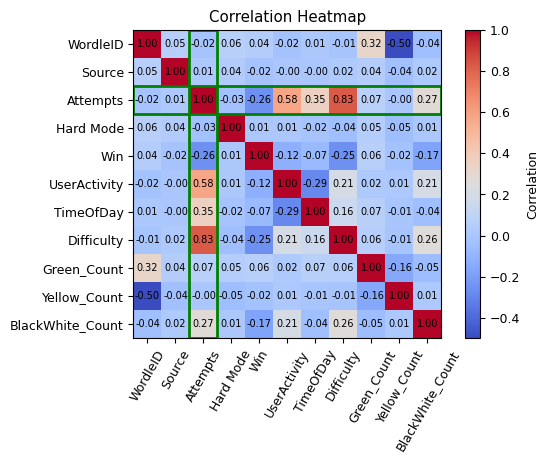

In [220]:
from matplotlib.patches import Rectangle

features = wordle_coded[['WordleID', 'Source', 'Attempts', 'Hard Mode', 'Win', 'UserActivity', 'TimeOfDay', 'Difficulty', 'Green_Count', 'Yellow_Count', 'BlackWhite_Count']]
wordle_norm = pd.DataFrame(scaler.fit_transform(wordle_coded), columns=features.columns)

r = wordle_norm.corr()

plt.figure(figsize=(6, 4))
plt.imshow(r, cmap='coolwarm', interpolation='nearest')

for i in range(len(r.columns)):
    for j in range(len(r.columns)):
        plt.text(j, i, "{:.2f}".format(r.iloc[i, j]), ha='center', va='center', color='black', fontsize=7)

highlight_row = r.index.get_loc('Attempts')
rect = Rectangle((-0.5, highlight_row - 0.5), len(r.columns), 1, linewidth=2, edgecolor='green', facecolor='none')
plt.gca().add_patch(rect)

highlight_col = r.columns.get_loc('Attempts')
col_rect = Rectangle((highlight_col - 0.5, -0.5), 1, len(r.columns), linewidth=2, edgecolor='green', facecolor='none')
plt.gca().add_patch(col_rect)

plt.colorbar(label='Correlation')
plt.title('Correlation Heatmap')
plt.xticks(range(len(r.columns)), r.columns, rotation=60)
plt.yticks(range(len(r.columns)), r.columns)
plt.show()

Va osservato che Green_Count, Yellow_Count e BlackWhite_Count non coincidono con il numero di lettere 'uniche', poichè per ciascuna categoria, un utente può aver inserire la stessa lettera più volte nello stesso tentativo o in più tentativi diversi (per esempio, al primo tentativo l'utente ha compreso che la A è la prima lettera, aumentando Green_Count di uno, al secondo tentativo può averla inserita nuovamente come prima lettera, aumentando Green_Count nuovamente di uno seppur la lettera sia la stessa).

E' allora interessante notare come l'informazione riguardante il numero di tentativi sia più facilmente ricavabile dal numero di lettere non presenti nella parola inserite dall'utente piuttosto che dal numero di lettere presenti nella parola inserite al posto sbagliato o dal numero di lettere presenti nella parola inserite nell'ordine corretto.

In aggiunta nel passaggio da Match al conteggio delle celle abbiamo perso un'informazione cruciale per il gioco di Wordle: il loro ordine. Se da un valore della caratteristica Match è immediato comprendere se una partita è stata vinta o meno, tutto ciò non è più così banale nel momento in cui cerchiamo di comprendere se c'è stata una vittoria o meno dal rispettivo numero di celle verdi, gialli e nere/bianche. Facciamo un esempio:

- Green_Count = 6, Yellow_Count = 2, BlackWhite_Count = 7. La partità è vinta?  
  La partita potrebbe essere andata così:  
  ⬛⬛⬛🟨🟩, 🟩🟨⬛⬛🟩, 🟩⬛⬛🟩🟩 -> La risposta alla domanda è no  
  Ma anche così:  
  ⬛⬛⬛🟨⬛, ⬛🟨⬛⬛🟩, 🟩🟩🟩🟩🟩 -> La risposta alla domanda è sì  
  Oppure così:  
  ⬛⬛🟩🟨⬛, ⬛🟨⬛⬛🟩, 🟩⬛🟩🟩🟩 -> La risposta alla domanda è no

- ⬛⬛⬛🟨⬛, ⬛🟨⬛⬛🟩, 🟩🟩🟩🟩🟩. La partità è vinta o meno?  
  La risposta alla domanda è sì.

Si può inoltre sottolineare la debole correlazione negativa tra il numero di tentativi e di vittorie. Si può immaginare che gli utenti non si arrendando subito, ai primi tentativi, e va ricordato che la partita è persa al sesto tentativo senza successo. 

Con il nostro modello predittivo vogliamo prevedere il numero di tentativi di un tweet. Ci interessiamo allora solamente alla riga (o equivalentemente alla colonna) che interessa Attempts. 
Proviamo a basare la nostra predizione sulle caratteristiche che sono maggiormente correlate (positivamente o negativamente) con il numero di tentativi. In questo caso proviamo in un primo momento a predire il numero di tentivi di un tweet sapendo se il tweet è vincente o meno e la difficoltà della parola da indovinare. In un secondo momento aggiungiamo in input l'informazione relativa al numero di lettere non presenti nella parola del giorno che l'utente ha inserito e sostituiamo l'informazione di Win con UserActivity e confrontiamo i risultati. 

In [221]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Dividi il dataset in features (X) e variabile dipendente (y)
X = wordle_coded[['Win', 'Difficulty']]
y = wordle_coded['Attempts']

scaler = MinMaxScaler()
X_scaled_regression = scaler.fit_transform(X)
# Dividi il dataset in set di addestramento e di test
X_train, X_test, y_train, y_test = train_test_split(X_scaled_regression, y, test_size=0.2, random_state=42)

# Crea un'istanza del modello di regressione lineare
model = LinearRegression()

# Addestra il modello sui dati di addestramento
model.fit(X_train, y_train)

# Fai previsioni sui dati di test
y_pred = model.predict(X_test)

mean_attempts = y_test.mean()

null_model_y = np.ones(len(y_test))*mean_attempts

print("MSE del nostro modello: ", MSE(y_pred, y_test))
print("MSE del modello nullo: ", MSE(null_model_y, y_test))

MSE del nostro modello:  0.879364400732295
MSE del modello nullo:  0.9393789755181636


Per verificare che il risultato ottenuto sia un buon risultato ricorriamo al modello nullo. L'errore del modello nullo deve essere maggiore dell'errore del modello che abbiamo ottenuto per poter dire di aver ottenuto un modello accettabile. In questo caso, il nostro modello è lievemente più accurato del modello nullo. 

In [222]:
# Dividi il dataset in features (X) e variabile dipendente (y)
X = wordle_coded[['UserActivity', 'Difficulty', 'BlackWhite_Count']]
y = wordle_coded['Attempts']

X_scaled_regression = scaler.fit_transform(X)
# Dividi il dataset in set di addestramento e di test
X_train, X_test, y_train, y_test = train_test_split(X_scaled_regression, y, test_size=0.2, random_state=42)

# Crea un'istanza del modello di regressione lineare
model = LinearRegression()

# Addestra il modello sui dati di addestramento
model.fit(X_train, y_train)

# Fai previsioni sui dati di test
y_pred = model.predict(X_test)

mean_attempts = y_test.mean()

null_model_y = np.ones(len(y_test))*mean_attempts

print("MSE del nostro modello: ", MSE(y_pred, y_test))
print("MSE del modello nullo: ", MSE(null_model_y, y_test))

MSE del nostro modello:  0.519359352206613
MSE del modello nullo:  0.9393789755181636


Il nostro modello, grazie all'informazione aggiunta, è più accurato del modello nullo e del modello precedente.

#### Wordle_Summary

Supponiamo di voler stimare una funzione che preveda il twitter win rate della prossima parola del giorno a partire dal numero complessivo di condivisioni, sia vincenti che non, con 3 tentativi, 4 tentativi e 6 tentativi e il numero di condivisioni con la modalità difficile. 

In [223]:
wordle_summary.head()

,WordleID,Number_of_Games,Number_of_Wins,Mean_Attempts_Victory,Win_Rate,Hard_Mode_Count,attempts_Win_1,attempts_Win_2,attempts_Win_3,attempts_Win_4,attempts_Win_5,attempts_Win_6,attempts_1,attempts_2,attempts_3,attempts_4,attempts_5,attempts_6
0,254,18694,18551,3.746698,99.235049,552,353,1795,5637,6331,3283,1152,353,1795,5637,6332,3283,1294
1,255,18592,18215,4.304200,97.972246,614,186,559,3275,6288,5322,2585,187,559,3275,6288,5322,2961
2,256,18797,18415,3.919033,97.967761,555,331,1727,5064,5377,3812,2104,332,1727,5064,5378,3812,2484
3,257,18866,18691,3.851158,99.072405,649,185,1665,5536,6202,3567,1536,185,1665,5536,6202,3569,1709
4,258,18691,18376,4.193187,98.314697,701,226,912,3629,6273,4991,2345,228,912,3629,6274,4992,2656


Ricorriamo nuovamente a una heatmap per visualizzare le caratteristiche che variano insieme. 

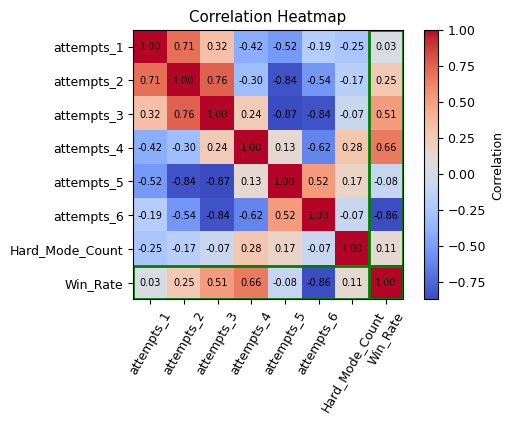

In [224]:
from matplotlib.patches import Rectangle

features = wordle_summary[['attempts_1', 'attempts_2', 'attempts_3','attempts_4' ,'attempts_5','attempts_6', 'Hard_Mode_Count', 'Win_Rate']]
wordle_norm = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)

r = wordle_norm.corr()

plt.figure(figsize=(5.5, 3.5))
plt.imshow(r, cmap='coolwarm', interpolation='nearest')

for i in range(len(r.columns)):
    for j in range(len(r.columns)):
        plt.text(j, i, "{:.2f}".format(r.iloc[i, j]), ha='center', va='center', color='black', fontsize=7)

highlight_row = r.index.get_loc('Win_Rate')  # Get the index of 'Win_Rate'
rect = Rectangle((-0.5, highlight_row - 0.5), len(r.columns), 1, linewidth=2, edgecolor='green', facecolor='none')
plt.gca().add_patch(rect)

highlight_col = r.columns.get_loc('Win_Rate')  # Get the index of 'Win_Rate'
col_rect = Rectangle((highlight_col - 0.5, -0.5), 1, len(r.columns), linewidth=2, edgecolor='green', facecolor='none')
plt.gca().add_patch(col_rect)

plt.colorbar(label='Correlation')
plt.title('Correlation Heatmap')
plt.xticks(range(len(r.columns)), r.columns, rotation=60)
plt.yticks(range(len(r.columns)), r.columns)
plt.show()

E' interessante notare come:
- il win rate sia scorrelato dal numero di condivisioni con un tentativo o cinque tentativi
- vi sia una correlazione positiva debole con il numero di condivisioni con due tentativi e con la modalità difficile
- vi sia una correlazione positiva moderata con il numero di condivisioni con tre tentativi e quattro tentativi
- vi sia una forte correlazione negativa con il numero di condivisioni con 6 tentativi 

In [225]:
# Dividiamo il dataset in features (X) e variabile dipendente (y)
X = wordle_summary[['attempts_3','attempts_4','attempts_6', 'Hard_Mode_Count']]
y = wordle_summary['Win_Rate']

# Scaliamo
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(X)
y_scaled = y

# Dividiaimo il dataset in set di addestramento e di test
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size=0.2, random_state=42)

# Creaiamo un'istanza del modello di regressione lineare
model = LinearRegression()

# Addestriamo il modello sui dati di addestramento
model.fit(X_train, y_train)

# Facciamo previsioni sui dati di test
y_pred = model.predict(X_test)

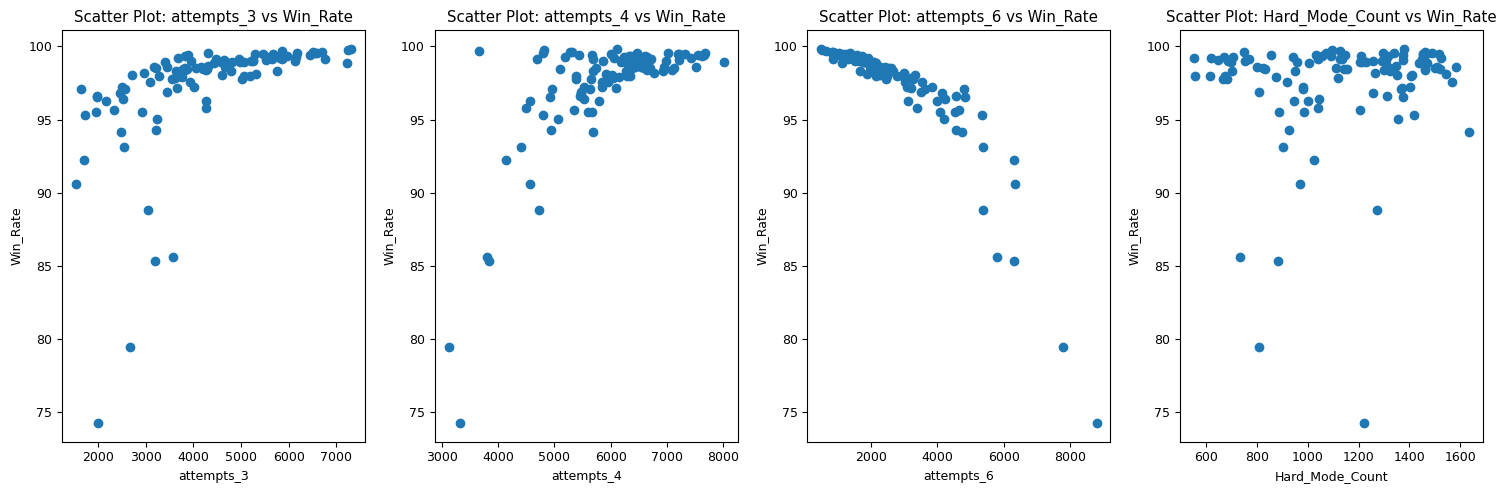

In [226]:
num_columns = X.shape[1]
plt.figure(figsize=(15, 5))

for i in range(num_columns):
    plt.subplot(1, num_columns, i+1)
    plt.scatter(X.iloc[:, i], y)
    plt.xlabel(X.columns[i])
    plt.ylabel('Win_Rate')
    plt.title(f'Scatter Plot: {X.columns[i]} vs Win_Rate')

plt.tight_layout()
plt.show()


Andiamo a confrontare il modello che abbiamo ottenuto con il modello nullo

In [227]:
mean_win_rate = y_test.mean()

null_model_y = np.ones(len(y_test))*mean_win_rate

print("MSE del nostro modello: ", MSE(y_pred, y_test))
print("MSE del modello nullo: ", MSE(null_model_y, y_test))

MSE del nostro modello:  0.8029354250631555
MSE del modello nullo:  2.9381860615887136


Anche in questo caso il nostro modello è più accurato del modello nullo.

### Regressione Logistica

In [228]:
wordle_coded.head()

,WordleID,Source,Attempts,Hard Mode,Win,Green_Count,Yellow_Count,BlackWhite_Count,UserActivity,TimeOfDay,Difficulty
0,254,1,3,0,1,6,4,5,1,3,1
1,254,1,4,0,1,9,0,11,3,3,1
2,254,1,3,0,1,8,0,7,1,3,1
3,254,1,3,0,1,6,2,7,1,3,1
4,254,1,3,0,1,9,1,5,1,3,1


Andiamo a vedere la regressione logistica, iniziamo basandoci solamente sugli attempts

In [229]:
from sklearn.linear_model import LogisticRegression

y = wordle_coded['Win']
x = wordle_coded[['Attempts']]
x = scaler.fit_transform(x)

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.2, random_state=16)
reg = LogisticRegression()
reg.fit(x_train, y_train)
y_pred = reg.predict(x_valid)

score_attempts = reg.score(x_valid, y_valid)

Proviamo invece basandoci su fattori diversi da attempts

In [230]:
y = wordle_coded['Win']
x = wordle_coded[['Green_Count','Yellow_Count','BlackWhite_Count','UserActivity','TimeOfDay','Hard Mode']]
x = scaler.fit_transform(x)

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.2, random_state=16)
reg = LogisticRegression()
reg.fit(x_train, y_train)
y_pred = reg.predict(x_valid)

score_multivar = reg.score(x_valid, y_valid)

Confrontiamo con il modello nullo

In [231]:
print(f'Righe in cui si ha una vincita: {np.sum(y==1)}')
print(f'Righe in cui si ha una sconfitta: {np.sum(y==0)}')

classe1 = np.sum(y_valid ==1)/x_valid.shape[0]

print("Performance del modello nullo: ",classe1)

def confronto_modello_nullo(score,nmodel_score):
    if(score == nmodel_score):
        print("Stessa precisione del modello nullo")
    elif (score > nmodel_score):
        print("Maggior precisione rispetto al modello nullo")
    else:
        print("Peggior precisione rispetto al modello nullo")

print("Regressione Logistica basata solamente sugli attempts: ",score_attempts)
confronto_modello_nullo(score_attempts, classe1)

print("Regressione Logistica basata su più variabili: ",score_multivar)
confronto_modello_nullo(score_multivar, classe1)


Righe in cui si ha una vincita: 1952040
Righe in cui si ha una sconfitta: 51588
Performance del modello nullo:  0.9741569052170311
Regressione Logistica basata solamente sugli attempts:  0.9741569052170311
Stessa precisione del modello nullo
Regressione Logistica basata su più variabili:  0.9745187484715242
Maggior precisione rispetto al modello nullo


In questo caso si nota che la regressione logistica basata solamente sugli attempts ha una performance pari al modello nullo. Questo può essere legato al fatto che le due parti (vittoria/non vittoria) sono fortemente sbilanciate in favore della vittoria. Nonostante ciò è interessante notare come la regressione logistica basata sulle altre variabili fornisca una precisione leggermente maggiore rispetto al tentativo di regressione basato solo sugli attempts, anche se non molto rilevante. Si può comunque dedurre che questo aumento di accuratezza è dovuto a un maggior contenuto informativo nel caso dell'analisi basata su più variabili.

### Clustering con K-Means

Proviamo a individuare dei cluster a partire dal dataframe _user_stats_. 
Poichè la computazione dell'indice di silhouette è onerosa in questo caso (il dataframe consta di 400000 campioni e 21 caratteristiche), decidiamo di farci guidare nella scelta di un K ottimale dal metodo del gomito.

In [265]:
user_clustering = user_stats.copy()

user_clustering.drop(columns=['UserActivity', 'UserID', 'Total_Attempts'],inplace=True)

user_clustering.head()

,Num_tweets,User_Wins,User_Win_Rate,Hard_Mode_Count,attempts_Win_1,attempts_Win_2,attempts_Win_3,attempts_Win_4,attempts_Win_5,attempts_Win_6,attempts_1,attempts_2,attempts_3,attempts_4,attempts_5,attempts_6,UserCurrentStreak,UserMaxStreak
0,1,1,100.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,1,1
1,1,1,100.0,1,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0,1,0,0,1,1
2,3,3,100.0,0,0.0,0.0,0.0,1.0,0.0,2.0,0,0,0,1,0,2,3,3
3,5,5,100.0,0,0.0,0.0,2.0,2.0,1.0,0.0,0,0,2,2,1,0,5,5
4,18,18,100.0,0,0.0,0.0,5.0,8.0,2.0,3.0,0,0,5,8,2,3,18,18


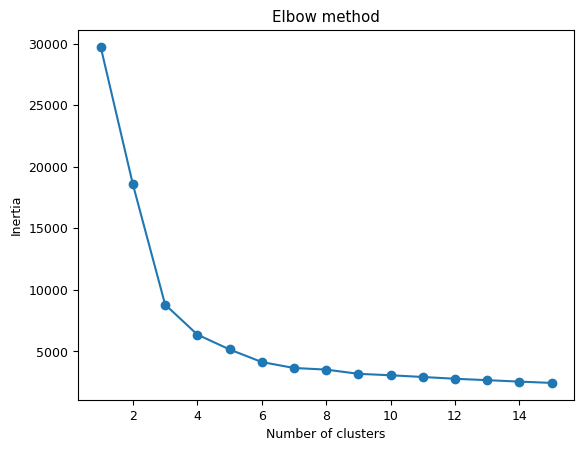

In [266]:
scaler = MinMaxScaler()

X_scaled_user = scaler.fit_transform(user_clustering)

inertias_user = []

for i in range(1,16):
    kmeans = KMeans(n_clusters=i, random_state=16)
    kmeans.fit(X_scaled_user)
    inertias_user.append(kmeans.inertia_)

plt.plot(range(1, 16), inertias_user, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

Prendiamo K = 4.

In [269]:
kmeans = KMeans(n_clusters=4, random_state=16)

kmeans.fit(X_scaled_user)

cluster_labels = kmeans.labels_

user_clustering['Cluster'] = cluster_labels

user_clustering.sample(5).head()

,Num_tweets,User_Wins,User_Win_Rate,Hard_Mode_Count,attempts_Win_1,attempts_Win_2,attempts_Win_3,attempts_Win_4,attempts_Win_5,attempts_Win_6,attempts_1,attempts_2,attempts_3,attempts_4,attempts_5,attempts_6,UserCurrentStreak,UserMaxStreak,Cluster
95050,1,1,100.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,1,1,0
328391,2,2,100.0,0,0.0,1.0,0.0,0.0,1.0,0.0,0,1,0,0,1,0,2,2,0
391334,7,7,100.0,0,0.0,0.0,2.0,3.0,2.0,0.0,0,0,2,3,2,0,7,7,0
357532,1,1,100.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,1,0,0,0,1,1,0
361940,1,1,100.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,1,0,0,0,1,1,0


Realizziamo alcuni grafici per fare alcune osservazioni sulle caratteristiche che accomunano i dati all'interno di uno stesso cluster. 

[333671, 12542, 14633, 45677]


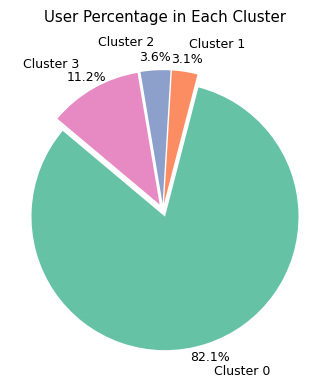

In [340]:
cluster_sizes = [
    user_clustering[user_clustering['Cluster'] == 0].shape[0],
    user_clustering[user_clustering['Cluster'] == 1].shape[0],
    user_clustering[user_clustering['Cluster'] == 2].shape[0],
    user_clustering[user_clustering['Cluster'] == 3].shape[0]
]

print(cluster_sizes)

user_percentages = [
    cluster_sizes[0] / user_clustering.shape[0] * 100,
    cluster_sizes[1] / user_clustering.shape[0] * 100,
    cluster_sizes[2] / user_clustering.shape[0] * 100,
    cluster_sizes[3] / user_clustering.shape[0] * 100
]

labels = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3']
explode = [0.05, 0.05, 0.05, 0.05]

plt.figure(figsize=(4, 4))
plt.pie(user_percentages, labels=labels, autopct='%1.1f%%', explode=explode, startangle=140, colors=colors, pctdistance=1.1, labeldistance=1.21)
pie = plt.title('User Percentage in Each Cluster', pad=25)
    
plt.axis('equal') 
plt.show()

Possiamo innanzitutto notare come il cluster 0 sia il più popoloso e corrisponda alla maggioranza degli utenti. 

In linea con il nostro obiettivo analitico, andiamo a vedere il numero medio di tweet per i vari cluster.

In [286]:
print(user_clustering[user_clustering['Cluster'] == 0]['Num_tweets'].mean())
print(user_clustering[user_clustering['Cluster'] == 1]['Num_tweets'].mean())
print(user_clustering[user_clustering['Cluster'] == 2]['Num_tweets'].mean())
print(user_clustering[user_clustering['Cluster'] == 3]['Num_tweets'].mean())

2.3456158911023133
41.321081167277946
1.561744003280257
14.884121111281388


Dall'analisi della media siamo portati a immaginare di trovare gli utenti molto attivi nel cluster 1, gli utenti attivi nel cluster 3 e a seguire i meno attivi nei cluster 0 e 1. Realizzando dei box plot vorremmo avere conferma di questa affermazione.

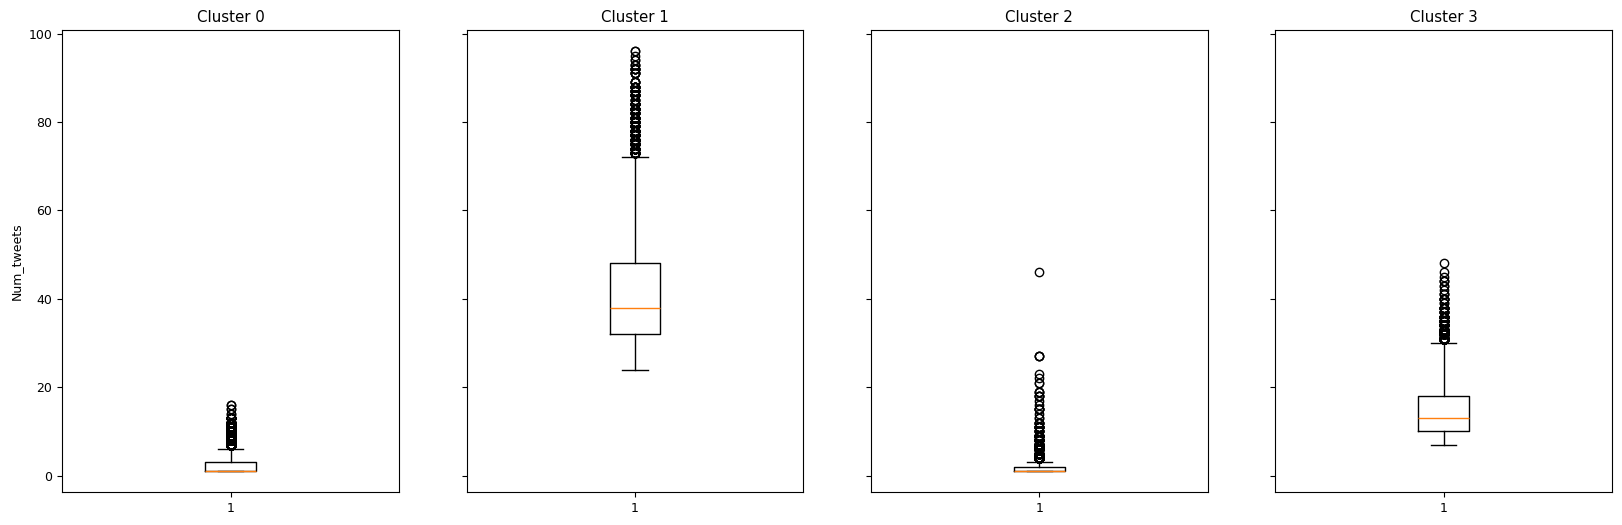

In [287]:
fig, axs = plt.subplots(1, 4, figsize=(20, 6), sharey=True)
clusters = [0, 1, 2, 3]

for i, cluster in enumerate(clusters):
    win_rates = user_clustering[user_clustering['Cluster'] == cluster]['Num_tweets']
    axs[i].boxplot(win_rates)
    axs[i].set_title(f'Cluster {cluster}')
    if i == 0:
        axs[i].set_ylabel('Num_tweets')

plt.show()

I box plot confermano quanto osservato.
Realizziamo altri grafici e compariamoli per costruire un overview generale sui cluster.

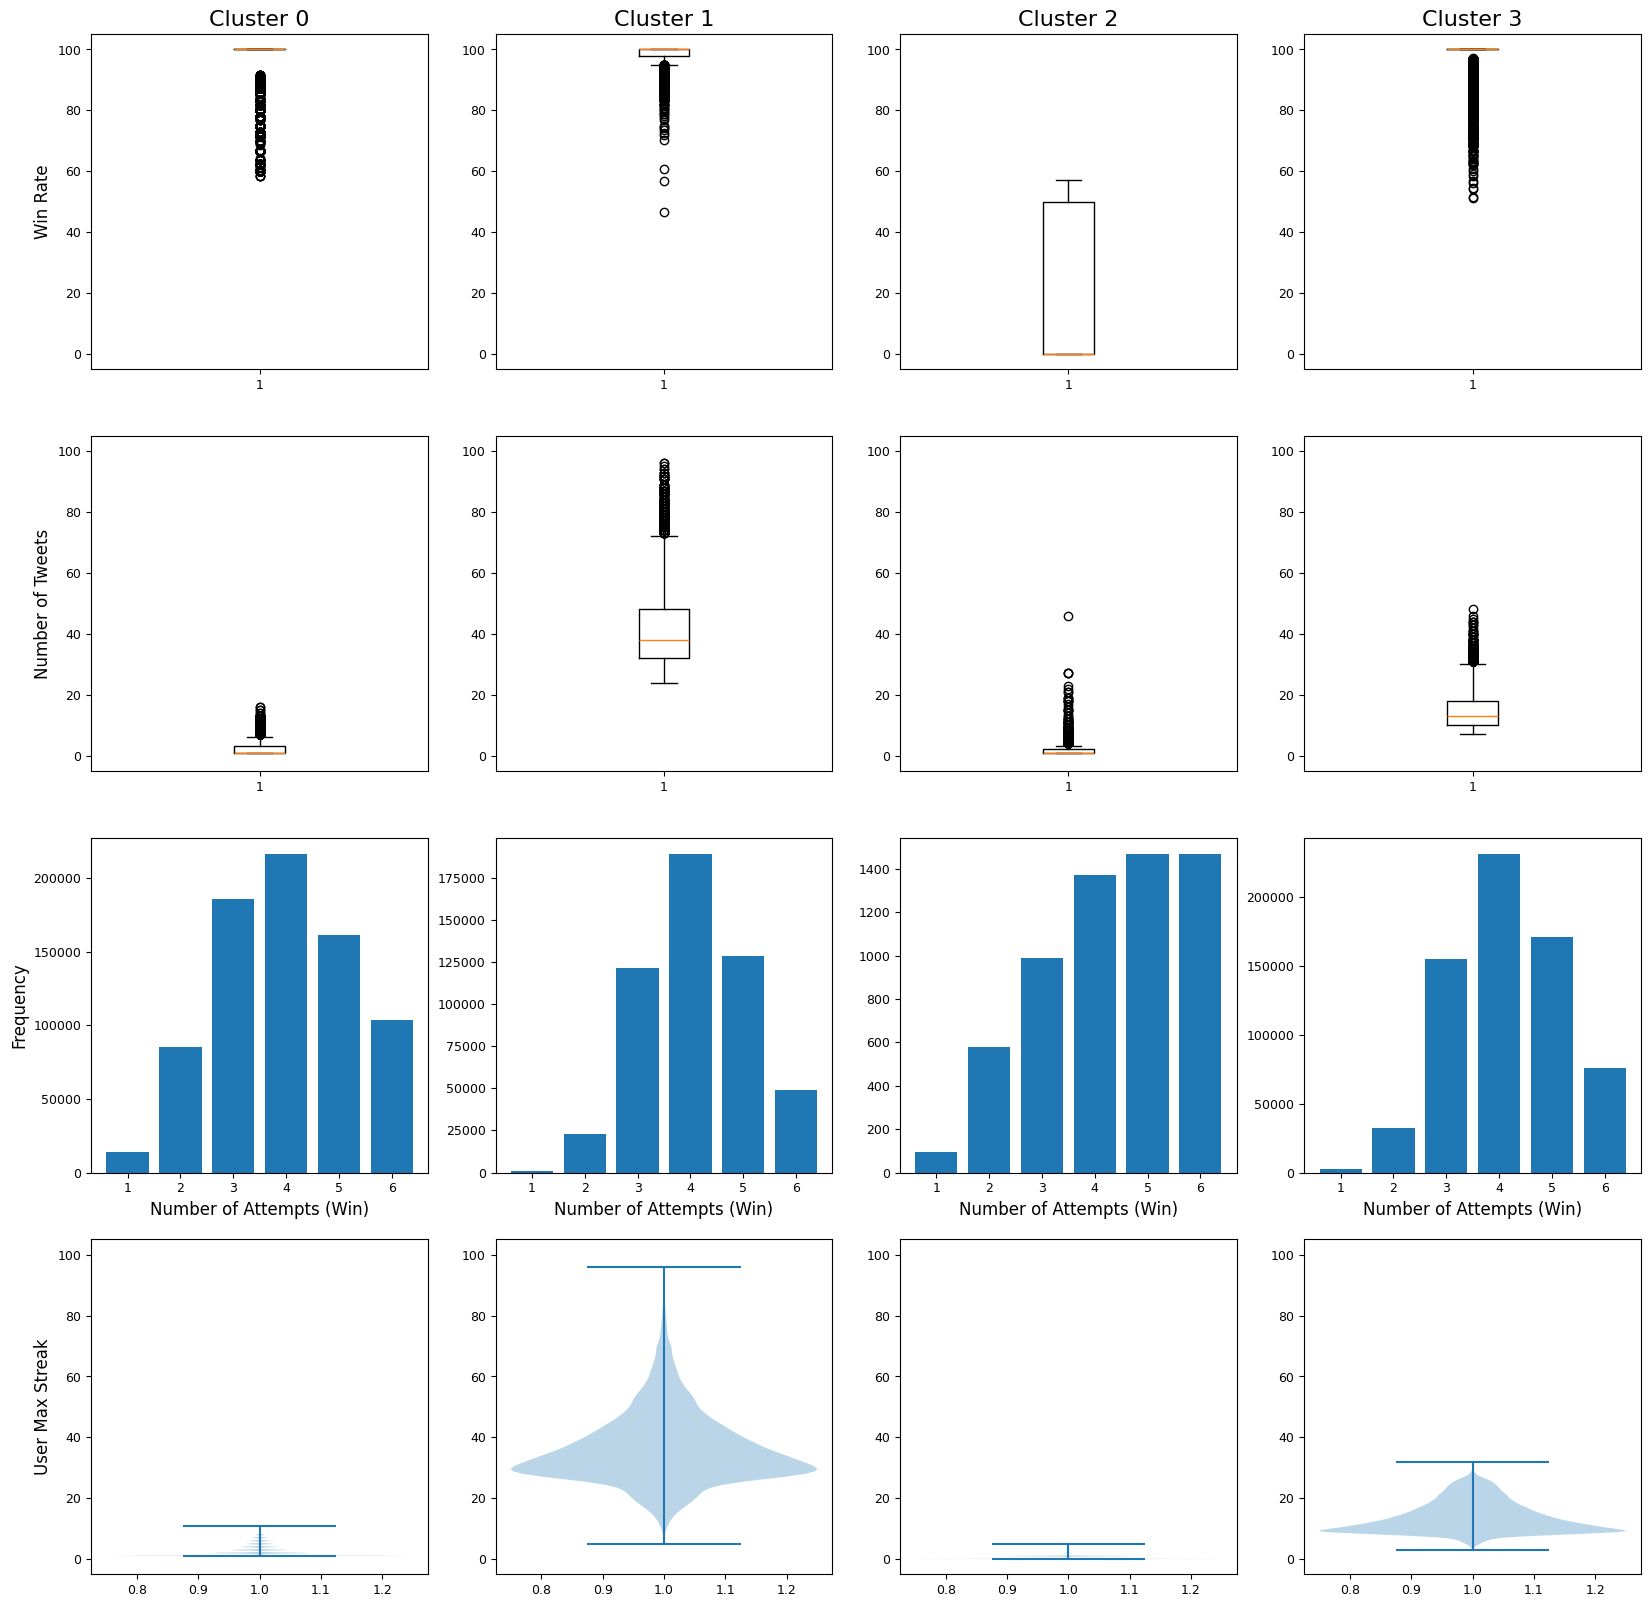

In [312]:
fig, axs = plt.subplots(4, 4, figsize=(20, 20))

for i, cluster in enumerate(clusters):
    win_rates = user_clustering[user_clustering['Cluster'] == cluster]['User_Win_Rate']
    axs[0, i].boxplot(win_rates)
    axs[0, i].set_title(f'Cluster {i}', fontsize=16)
    if i==0:
        axs[0, i].set_ylabel('Win Rate', fontsize=12)
    axs[0, i].set_ylim(-5,105)

    win_rates = user_clustering[user_clustering['Cluster'] == cluster]['Num_tweets']
    axs[1, i].boxplot(win_rates)
    if i==0:
        axs[1, i].set_ylabel('Number of Tweets', fontsize=12)
    axs[1, i].set_ylim(-5,105)

    cluster_attempts = user_clustering.groupby('Cluster')[['attempts_Win_1', 'attempts_Win_2', 'attempts_Win_3', 'attempts_Win_4', 'attempts_Win_5', 'attempts_Win_6']].sum()
    axs[2, i].bar(range(1, 7), cluster_attempts.loc[cluster])
    axs[2, i].set_xlabel('Number of Attempts (Win)', fontsize=12)
    if i==0:
        axs[2, i].set_ylabel('Frequency', fontsize=12)
    axs[2, i].set_xticks(range(1, 7))

    cluster_streaks = user_clustering[user_clustering['Cluster'] == cluster]['UserMaxStreak']
    axs[3,i].violinplot(cluster_streaks)
    if i == 0:
        axs[3, i].set_ylabel('User Max Streak', fontsize=12)
    axs[3, i].set_ylim(-5,105)
    
plt.show()

In primo luogo possiamo notare come nei cluster 0 e 3 sia raccolti gli utenti con tasso di vincita sia estremamente alto, coincidente col 100%. Anche nel cluster 1 il tasso di vincita è alto, ma più concentrato nell'intervallo tra il 95 e il 100% e più basso dei primi due. Nel cluster 2 sono presenti tutti gli utenti con un tasso di vincinta inferiore al 60%. Si può notare come in quest'ultimo la mediana sia protesa verso il basso: metà degli utenti nel cluster 2 ha un tasso di vincita dello 0%, mentre l'altrà meta compreso tra 0% e 50% circa.
Verifichiamo quanto osservato:

In [304]:
print("Cluster 0 first User Win Rate quartile: ", user_clustering[user_clustering['Cluster'] == 0]['User_Win_Rate'].quantile(0.25))
print("Cluster 3 first User Win Rate quartile: ",user_clustering[user_clustering['Cluster'] == 3]['User_Win_Rate'].quantile(0.25))
print("Cluster 2 first User Win Rate median: ",user_clustering[user_clustering['Cluster'] == 2]['User_Win_Rate'].quantile(0.5))

Cluster 0 first User Win Rate quartile:  100.0
Cluster 3 first User Win Rate quartile:  100.0
Cluster 2 first User Win Rate median:  0.0


Osserviamo in secondo luogo la distribuzione dei tentativi in caso di vittoria. Notiamo come questa distribuzione sia molto simile nei cluster 1 e 3, dove riscrontriamo un picco in 4 tentativi. Anche la scala non è molto diversa: nel primo il picco supera la frequenza di 175000, mentre nel terzo il picco supera la frequenza di 200000. Ricordiamo che però il cluster 1 era costituito da circa 12500 utenti, mentre il cluster 3 da 45500, quindi più del triplo. Cosa potrebbe giustificare allora questa similarità nella scala della distribuzione? La risposta potrebbe risiedere nel fatto che gli utenti del cluster 1 siano più attivi degli utenti del cluster 3.  
La distribuzione di tenativi nel cluster 2 è diversa dalle altre: non presenta un picco, bensì cresce fino ad assestarsi su un valore. Il numero di tentativi più frequente non è 4 come negli altri casi ma è 5 e 6. La scala delle frequenze è significativamente più bassa, eppure la popolosità del cluster 2 è confrontabile con quella del cluster 1. Questo non ci deve sorprendere: nel cluster 2 sono presenti gli utenti poco attivi e con un tasso di vincita basso. Pochi tweet e ancor meno tweet vincenti abbasano la scala delle frequenze. 

Infine il violin plot dei cluster 0 sul numero massimo di vittorie consecutive per utente risulta coerente con la presenza nel cluster 0 di utenti poco attivi (pochi tweet->poche vittorie consecuive). Allo stesso modo le poche vittorie consecutive nel cluster 2 rispecchiano il basso tasso di vincita e di condivisione da parte degli utenti che vi appartengono. Il fatto che il violin plot del cluster 1 ammetta la presenza di valori bassi per il numero massimo di vittorie consecutive, ci porta a ipotizzare che alcuni utenti molto attivi e propensi a vincere ciclicamente perdano una partita, azzerando questo valore. Questo è coerente con la distribuzione del tasso di vincita del clsuter 1 lievemente ribassata rispetto al cluster 0 e 3. 

Riassumendo:
- cluster 0: molti utenti poco attivi ma propensi a vincere
- cluster 2: pochi utenti poco attivi ma propensi a perdere
- cluster 1: pochi utenti molto attivi e propensi a vincere
- cluster 3: utenti attivi e propensi a vincere

~~Per curiosità, andiamo a vedere la distribuzione dei client nei vari cluster~~

In [167]:
'''fig, axs = plt.subplots(1, 4, figsize=(5, 5))

for i, cluster in enumerate(clusters):
    cluster_clients = user_clustering[user_clustering['Cluster'] == cluster]['Source']
    valori_client = cluster_clients['Source'].value_counts()
    axs[i].pie(valori_client, labels=valori_client.index, startangle=140, colors=colors)
    axs[i].rcParams['font.size'] = 9

    # Get the wedges and labels of the pie chart
    wedges, labels = pie[0], pie[1]

    for i, (wedge, label) in enumerate(zip(wedges, labels)):
        percentage = 100 * valori_client.iloc[i] / valori_client.sum()
        label.set_text(f"{label.get_text()} ({percentage:.1f}%)")

plt.title('Distribuzione dei client')
plt.show()'''

'fig, axs = plt.subplots(1, 4, figsize=(5, 5))\n\nfor i, cluster in enumerate(clusters):\n    cluster_clients = user_clustering[user_clustering[\'Cluster\'] == cluster][\'Source\']\n    valori_client = cluster_clients[\'Source\'].value_counts()\n    axs[i].pie(valori_client, labels=valori_client.index, startangle=140, colors=colors)\n    axs[i].rcParams[\'font.size\'] = 9\n\n    # Get the wedges and labels of the pie chart\n    wedges, labels = pie[0], pie[1]\n\n    for i, (wedge, label) in enumerate(zip(wedges, labels)):\n        percentage = 100 * valori_client.iloc[i] / valori_client.sum()\n        label.set_text(f"{label.get_text()} ({percentage:.1f}%)")\n\nplt.title(\'Distribuzione dei client\')\nplt.show()'